# Train neural MCTS

---

Author: S. Menary [sbmenary@gmail.com]

Date  : 2023-01-24, last edit 2023-01-24

Brief : Perform many bot training iterations

---

## Imports

---

In [1]:
##=====================================##
##  All imports should be placed here  ##
##=====================================##

##  Python core libs
import pickle, sys, time

##  PyPI libs
import numpy as np
from matplotlib import pyplot as plt

##  Local packages
from connect4.utils    import DebugLevel
from connect4.game     import BinaryPlayer, GameBoard, GameResult
from connect4.MCTS     import Node_NeuralMCTS, PolicyStrategy
from connect4.bot      import Bot_NeuralMCTS, Bot_VanillaMCTS
from connect4.parallel import generate_from_processes, global_info, thread_info, process_lock, thread_lock
from connect4.methods  import get_training_data_from_bot_game, play_bot_game


In [2]:
##=====================================##
##  Print version for reproducibility  ##
##=====================================##

print(f"{'Python'    .rjust(12)} version is {sys.version}")
print(f"{'Numpy'     .rjust(12)} version is {np.__version__}")


      Python version is 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:29) [Clang 14.0.6 ]
       Numpy version is 1.23.2


---

##  Global config

---

In [3]:
##============================##
##  Set global config values  ##
##============================##

run_tag = "test_run"

num_processes      = 7
num_games_per_proc = 500
base_seed          = int(time.time())
duration           = .3
discount           = 0.99
monitor_frequency  = 3
num_random_moves   = 3
policy_strategy    = PolicyStrategy.NOISY_POSTERIOR_POLICY
noise_level        = 0.25
num_games          = num_processes * num_games_per_proc

num_eval_processes = 7
num_evals_per_proc = 50
eval_duration      = .3


---

## Data generation and preprocessing

---

In [4]:
##========================================================##
##  Define methods for data generation and preprocessing  ##
##========================================================##

##  N.B. connect4.neural import must be performed inside the method executed inside each child process
##  to avoid a deadlock caused when a tf session has already been created in __main__


def generate_datapoints_process(proc_idx, num_games, out_queue, func_args) :
    
    ##  Import neural methods
    from connect4.neural import load_model
    
    ##  Resolve function args
    model_name, duration, discount, num_random_moves, policy_strategy, noise_level, base_seed = func_args
    
    ##  Load keras model once per processes
    model = load_model(model_name) if model_name else None
    
    ##  Loop over games and add generated data to the output Queue
    np.random.seed(base_seed+proc_idx)
    for game_idx in range(num_games) :
        _ = get_training_data_from_bot_game(model, duration, discount, num_random_moves, 
                                            policy_strategy, noise_level)
        out_queue.put(_)

        
def generate_data(model_name) :
    
    ##  Run subprocesses to generate new data
    print(f"Generating {num_games} games with base seed {base_seed}")
    print(f"Using duration = {duration:.3f}\nUsing discount = {discount:.3f}")
    results = generate_from_processes(
        func                 = generate_datapoints_process, 
        func_args            = [model_name, duration, discount, num_random_moves, policy_strategy, noise_level, base_seed],
        num_proc             = num_processes, 
        num_results_per_proc = num_games_per_proc, 
        mon_freq             = monitor_frequency)
                              
    ##  Retrieve training data from worker thread
    model_in = np.concatenate([r[0] for r in results])
    model_p  = np.concatenate([r[1] for r in results])
    model_v  = np.concatenate([r[2] for r in results])
    num_data = len(model_in)
    print(f"Generated {num_data} datapoints with average of {num_data/num_games:.1f} turns per game")
    print(f"model_in with shape: {model_in.shape}")
    print(f"model_p  with shape: {model_p .shape}")
    print(f"model_v  with shape: {model_v .shape}")
    
    ##  Return data
    return model_in, model_p, model_v


def save_data(data_fname:str, model_in, model_p, model_v) :
    ##  Create dictionary containing data objects and a record of settings used
    to_save = {"model_in":model_in, "model_p":model_p, "model_v":model_v, 
               "base_seed":base_seed, "duration":duration, "discount":discount, 
               "num_random_moves":num_random_moves, "policy_strategy":policy_strategy,
               "noise_level":noise_level}
    
    ##  Dump dictionary to pickle file
    pickle.dump(to_save, open(data_fname, "wb"))
    
    
def augment_and_split_data(model_in, model_p, model_v) :

    ##  Randomly flip data along x-axis
    for idx in range(len(model_in)) :
        if np.random.choice([True, False]) : continue
        model_in[idx] = np.flip(model_in[idx], axis=0)
        model_p [idx] = np.flip(model_p [idx], axis=0)
        
    ##  Shuffle data
    indices = np.arange(len(model_in))
    np.random.shuffle(indices)
    model_in, model_p, model_v = model_in[indices], model_p [indices], model_v [indices]

    ##  Split data into train and val sets
    split_idx      = int(0.7*len(model_in))
    train_model_in = model_in[:split_idx]
    train_model_p  = model_p [:split_idx]
    train_model_v  = model_v [:split_idx]
    val_model_in   = model_in[split_idx:]
    val_model_p    = model_p [split_idx:]
    val_model_v    = model_v [split_idx:]

    ##  Return training and validation data
    print(f"Created training set of size {len(train_model_v)}")
    print(f"Created validation set of size {len(val_model_v)}")
    return (train_model_in, train_model_p, train_model_v), (val_model_in, val_model_p, val_model_v)



In [5]:

def train_model_process(proc_idx, num_games, out_queue, func_args) :
    
    ##  Import neural methods
    from connect4.neural import create_model, load_model
    from tensorflow.keras.callbacks import EarlyStopping

    ##  Resolve function args
    train_data, val_data, model_name, save_fname = func_args
    train_model_in, train_model_p, train_model_v = train_data
    val_model_in  , val_model_p  , val_model_v   = val_data
    
    ##  Load or create model
    '''if model_name :
        global_info(f"\rLoading model {model_name}\n")
        model = load_model(model_name)
    else :'''
    global_info("\rCreating new model\n")
    model = create_model(name="policy_value_model", num_conv_blocks=4, num_filters=40, num_dense=5, 
                         dense_width=200, batch_norm=True)

    ##  Print model summary
    thread_lock.acquire()
    process_lock.acquire()
    print("\rModel summary:")
    model.summary()
    
    ##  Train the model
    print("Model history:")
    history = model.fit(
                train_model_in, [train_model_p, train_model_v],
                validation_data=(val_model_in, [val_model_p, val_model_v]),
                epochs=1000, batch_size=100,
                callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)])
    process_lock.release()
    thread_lock.release()

    ##  Save the new model
    global_info(f"\rSaving model to file {save_fname}\n")
    model.save(save_fname)
    
    ##  Trigger end of process
    out_queue.put(history.history)
    
    
def train_model(train_data, val_data, old_model_name, new_model_name) :
    
    ##  Run subprocess to train model
    results = generate_from_processes(
        func                 = train_model_process, 
        func_args            = [train_data, val_data, old_model_name, new_model_name],
        num_proc             = 1, 
        num_results_per_proc = 1, 
        mon_freq             = -1)
    
    ##  Return history
    return results[0]
        

In [6]:
def show_history(history) :
    ##  Define metrics to track
    metrics     = ["loss", "policy_loss", "value_loss"]
    num_metrics = len(metrics)

    ##  Plot metrics on both linear and log scales
    for do_log in [False, True] :

        ##  Create, show and close figure showing training curves (one axis per metric)
        fig = plt.figure(figsize=(4*num_metrics, 3))
        for ax_idx, metric in enumerate(metrics) :
            val_metric = f"val_{metric}"
            ax  = fig.add_subplot(1, num_metrics, 1+ax_idx)
            ax.plot(history[metric], "-", lw=3, c="r", alpha=0.5, label=metric)
            if val_metric in history :
                ax.plot(history[val_metric], "-", lw=3, c="b", alpha=0.5, label=val_metric)
            ax.legend(loc="upper right", frameon=False, fontsize=10)
            ax.set_xlabel("Epoch", labelpad=15, fontsize=11, ha="center", va="top")
            if do_log : ax.set_yscale("log")
        plt.show(fig)
        plt.close(fig)

In [7]:

def bot_tournament_process(proc_idx, num_games, out_queue, argv) :
    from connect4.neural import load_model
    model_fname, duration, discount, seed = argv
    model = load_model(model_fname)
    np.random.seed(seed)
    for game_idx in range(num_games) :
        _ = play_bot_game(None, model, duration=duration, discount=discount, 
                          bot1_policy=PolicyStrategy.GREEDY_POSTERIOR_POLICY, 
                          bot2_policy=PolicyStrategy.GREEDY_POSTERIOR_POLICY)
        out_queue.put(_)
        
        
def evaluate_model(model_name, eval_fname, seed=1234) :
    print(f"Evaluating model {model_name}")
    results = generate_from_processes(
        func      = bot_tournament_process,
        func_args = [model_name, eval_duration, discount, seed],
        num_proc  = num_eval_processes, 
        num_results_per_proc = num_evals_per_proc, 
        mon_freq  = 3)
    
    print(f"Saving tournament results to file {eval_fname}")
    to_save = {"results"     : results,
               "num_results" : len(results),
               "seed"        : seed,
               "duration"    : duration,
               "discount"    : discount}
    pickle.dump(to_save, open(eval_fname, "wb"))
    
    print(f"Evaluating results")
    score = [[0, 0, 0, 0], [0, 0, 0, 0]]
    for result in results :
        score_idx = 0 if result["model1"] == BinaryPlayer.X else 1
        result_idx = 0
        if result["result"] == GameResult.X    : result_idx = 1
        if result["result"] == GameResult.DRAW : result_idx = 2
        if result["result"] == GameResult.O    : result_idx = 3
        score[score_idx][result_idx] += 1

    print("Results (LHS player goes first):")
    print(f"  [VANILLA]  {score[0][1]} - {score[0][2]} - {score[0][3]}  [NEW MODEL]")
    print(f"[NEW MODEL]  {score[1][1]} - {score[1][2]} - {score[1][3]}  [VANILLA]")


In [8]:

def train_model_iteration(model_idx:int) :
    
    old_model_name = f"../models/{run_tag}/neural_model_v{model_idx-1}.h5" if model_idx > 1 else None
    new_model_name = f"../models/{run_tag}/neural_model_v{model_idx}.h5"
    data_fname     = f"../data/{run_tag}/training_data_v{model_idx}.pickle"
    eval_fname     = f"../data/{run_tag}/eval_data_v{model_idx}.pickle"
    
    print(f"Using old model: {old_model_name}\nUsing new model: {new_model_name}\nUsing data file: {data_fname}")
    
    print(f"Generating data")
    data = generate_data(old_model_name)
    
    print(f"Saving data to file: {data_fname}")
    save_data(data_fname, *data)
    
    print(f"Pre-processing and splitting data")
    train_data, val_data = augment_and_split_data(*data)
    
    print(f"Begin model training")
    history = train_model(train_data, val_data, old_model_name, new_model_name)
    
    print(f"Showing training curves")
    show_history(history)
    
    print(f"Evaluating model")
    evaluate_model(new_model_name, eval_fname)


Using old model: None
Using new model: ../models/test_run/neural_model_v1.h5
Using data file: ../data/test_run/training_data_v1.pickle
Generating data
Generating 3500 games with base seed 1674569718
Using duration = 0.300
Using discount = 0.990
Generated 3500 / 3500 results [t=2664.19s]
Generation complete [t=2664.19s] [n=3500]
Generated 59469 datapoints with average of 17.0 turns per game
model_in with shape: (59469, 7, 6, 1)
model_p  with shape: (59469, 7)
model_v  with shape: (59469, 1)
Saving data to file: ../data/test_run/training_data_v1.pickle
Pre-processing and splitting data
Created training set of size 41628
Created validation set of size 17841
Begin model training
Creating new model
Model summary:
Model: "policy_value_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 game_board_input (InputLayer)  [(None, 7, 6, 1)]    0  

                                                                                                  
 dense4_batchnorm (BatchNormali  (None, 200)         800         ['dense4_feedforward[0][0]']     
 zation)                                                                                          
                                                                                                  
 dense4_dropout (Dropout)       (None, 200)          0           ['dense4_batchnorm[0][0]']       
                                                                                                  
 policy_process (Dense)         (None, 200)          40200       ['dense4_dropout[0][0]']         
                                                                                                  
 policy_logit (Dense)           (None, 7)            1407        ['policy_process[0][0]']         
                                                                                                  
 value_pro

2023-01-24 14:59:44.623780: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


417/417 [==============================] - 18s 40ms/step - loss: 2.9098 - policy_loss: 1.9846 - value_loss: 0.9251 - val_loss: 2.7760 - val_policy_loss: 1.9472 - val_value_loss: 0.8287
Epoch 2/1000
417/417 [==============================] - 19s 46ms/step - loss: 2.7666 - policy_loss: 1.9470 - value_loss: 0.8196 - val_loss: 2.7293 - val_policy_loss: 1.9413 - val_value_loss: 0.7880
Epoch 3/1000
417/417 [==============================] - 20s 49ms/step - loss: 2.7248 - policy_loss: 1.9406 - value_loss: 0.7843 - val_loss: 2.6989 - val_policy_loss: 1.9370 - val_value_loss: 0.7618
Epoch 4/1000
417/417 [==============================] - 20s 48ms/step - loss: 2.6976 - policy_loss: 1.9373 - value_loss: 0.7603 - val_loss: 2.6788 - val_policy_loss: 1.9337 - val_value_loss: 0.7451
Epoch 5/1000
417/417 [==============================] - 20s 48ms/step - loss: 2.6787 - policy_loss: 1.9348 - value_loss: 0.7439 - val_loss: 2.6665 - val_policy_loss: 1.9321 - val_value_loss: 0.7344
Epoch 6/1000
417/417 [=

417/417 [==============================] - 19s 46ms/step - loss: 2.3415 - policy_loss: 1.9102 - value_loss: 0.4313 - val_loss: 2.5954 - val_policy_loss: 1.9131 - val_value_loss: 0.6824
Epoch 43/1000
417/417 [==============================] - 20s 47ms/step - loss: 2.3383 - policy_loss: 1.9099 - value_loss: 0.4284 - val_loss: 2.6368 - val_policy_loss: 1.9148 - val_value_loss: 0.7221
Epoch 44/1000
417/417 [==============================] - 20s 48ms/step - loss: 2.3388 - policy_loss: 1.9094 - value_loss: 0.4294 - val_loss: 2.5967 - val_policy_loss: 1.9121 - val_value_loss: 0.6846
Epoch 45/1000
417/417 [==============================] - 19s 46ms/step - loss: 2.3364 - policy_loss: 1.9103 - value_loss: 0.4261 - val_loss: 2.6220 - val_policy_loss: 1.9131 - val_value_loss: 0.7089
Epoch 46/1000
417/417 [==============================] - 18s 44ms/step - loss: 2.3331 - policy_loss: 1.9100 - value_loss: 0.4232 - val_loss: 2.5971 - val_policy_loss: 1.9123 - val_value_loss: 0.6848
Epoch 47/1000
417/4

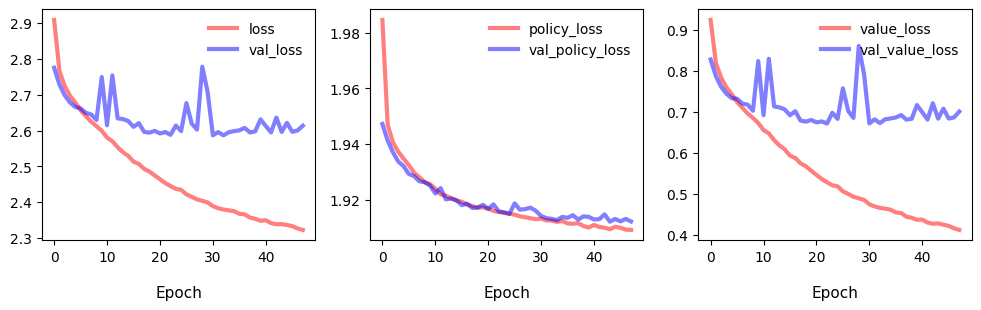

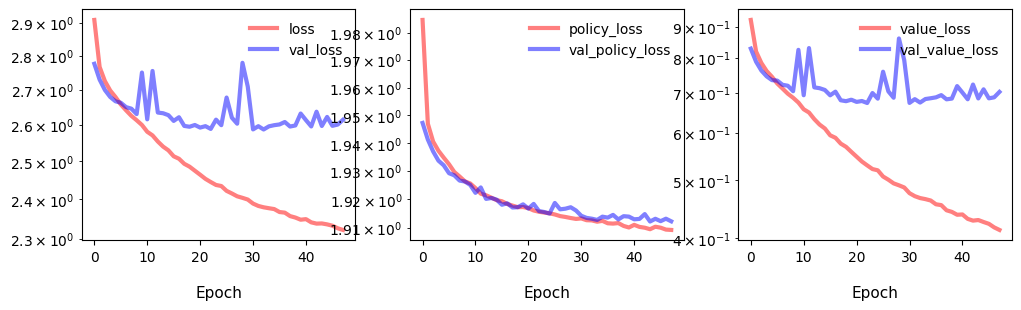

Evaluating model
Evaluating model ../models/test_run/neural_model_v1.h5
Generated 350 / 350 results [t=411.65s]
Generation complete [t=411.65s] [n=350]
Saving tournament results to file ../data/test_run/eval_data_v1.pickle
Evaluating results
Results (LHS player goes first):
  [VANILLA]  98 - 9 - 65  [NEW MODEL]
[NEW MODEL]  112 - 4 - 62  [VANILLA]
Using old model: ../models/test_run/neural_model_v1.h5
Using new model: ../models/test_run/neural_model_v2.h5
Using data file: ../data/test_run/training_data_v2.pickle
Generating data
Generating 3500 games with base seed 1674573738
Using duration = 0.300
Using discount = 0.990
Generated 3500 / 3500 results [t=2740.30s]
Generation complete [t=2740.30s] [n=3500]
Generated 59557 datapoints with average of 17.0 turns per game
model_in with shape: (59557, 7, 6, 1)
model_p  with shape: (59557, 7)
model_v  with shape: (59557, 1)
Saving data to file: ../data/test_run/training_data_v2.pickle
Pre-processing and splitting data
Created training set of si

                                                                                                  
 dense3_dropout (Dropout)       (None, 200)          0           ['dense3_batchnorm[0][0]']       
                                                                                                  
 dense4_feedforward (Dense)     (None, 200)          40200       ['dense3_dropout[0][0]']         
                                                                                                  
 dense4_batchnorm (BatchNormali  (None, 200)         800         ['dense4_feedforward[0][0]']     
 zation)                                                                                          
                                                                                                  
 dense4_dropout (Dropout)       (None, 200)          0           ['dense4_batchnorm[0][0]']       
                                                                                                  
 policy_pr

2023-01-24 16:08:01.237323: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


417/417 [==============================] - 18s 40ms/step - loss: 2.8643 - policy_loss: 1.9296 - value_loss: 0.9346 - val_loss: 2.6909 - val_policy_loss: 1.8527 - val_value_loss: 0.8382
Epoch 2/1000
417/417 [==============================] - 18s 43ms/step - loss: 2.6830 - policy_loss: 1.8595 - value_loss: 0.8235 - val_loss: 2.6221 - val_policy_loss: 1.8193 - val_value_loss: 0.8028
Epoch 3/1000
417/417 [==============================] - 18s 44ms/step - loss: 2.6058 - policy_loss: 1.8245 - value_loss: 0.7813 - val_loss: 2.5635 - val_policy_loss: 1.7914 - val_value_loss: 0.7721
Epoch 4/1000
417/417 [==============================] - 20s 47ms/step - loss: 2.5585 - policy_loss: 1.7976 - value_loss: 0.7609 - val_loss: 2.5344 - val_policy_loss: 1.7679 - val_value_loss: 0.7666
Epoch 5/1000
417/417 [==============================] - 19s 45ms/step - loss: 2.5273 - policy_loss: 1.7803 - value_loss: 0.7470 - val_loss: 2.5261 - val_policy_loss: 1.7597 - val_value_loss: 0.7664
Epoch 6/1000
417/417 [=

417/417 [==============================] - 19s 47ms/step - loss: 2.1154 - policy_loss: 1.6637 - value_loss: 0.4517 - val_loss: 2.3894 - val_policy_loss: 1.6927 - val_value_loss: 0.6967
Epoch 43/1000
417/417 [==============================] - 19s 46ms/step - loss: 2.1080 - policy_loss: 1.6604 - value_loss: 0.4476 - val_loss: 2.4267 - val_policy_loss: 1.7000 - val_value_loss: 0.7267
Epoch 44/1000
417/417 [==============================] - 19s 45ms/step - loss: 2.1055 - policy_loss: 1.6597 - value_loss: 0.4458 - val_loss: 2.4084 - val_policy_loss: 1.7017 - val_value_loss: 0.7067
Epoch 45/1000
417/417 [==============================] - 19s 45ms/step - loss: 2.1068 - policy_loss: 1.6603 - value_loss: 0.4466 - val_loss: 2.3908 - val_policy_loss: 1.6931 - val_value_loss: 0.6978
Epoch 46/1000
417/417 [==============================] - 19s 45ms/step - loss: 2.0999 - policy_loss: 1.6579 - value_loss: 0.4420 - val_loss: 2.4152 - val_policy_loss: 1.6974 - val_value_loss: 0.7178
Epoch 47/1000
417/4

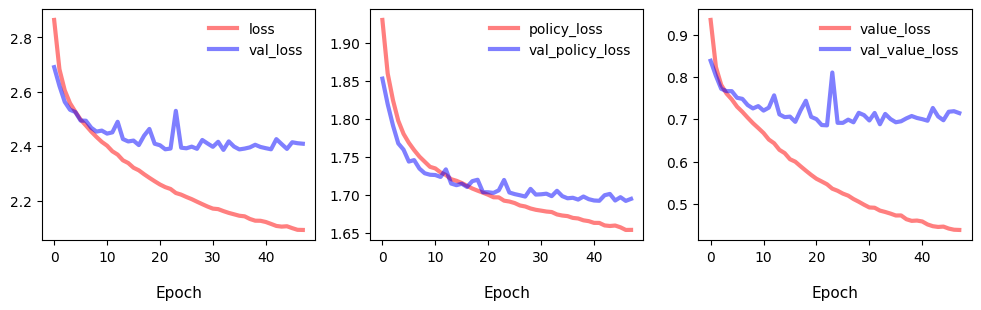

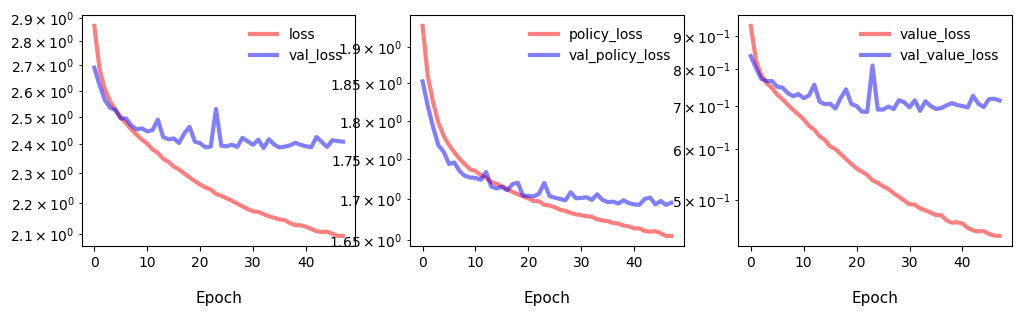

Evaluating model
Evaluating model ../models/test_run/neural_model_v2.h5
Generated 350 / 350 results [t=381.92s]
Generation complete [t=381.92s] [n=350]
Saving tournament results to file ../data/test_run/eval_data_v2.pickle
Evaluating results
Results (LHS player goes first):
  [VANILLA]  85 - 6 - 83  [NEW MODEL]
[NEW MODEL]  106 - 5 - 65  [VANILLA]
Using old model: ../models/test_run/neural_model_v2.h5
Using new model: ../models/test_run/neural_model_v3.h5
Using data file: ../data/test_run/training_data_v3.pickle
Generating data
Generating 3500 games with base seed 1674577811
Using duration = 0.300
Using discount = 0.990
Generated 3500 / 3500 results [t=2816.37s]
Generation complete [t=2816.37s] [n=3500]
Generated 61554 datapoints with average of 17.6 turns per game
model_in with shape: (61554, 7, 6, 1)
model_p  with shape: (61554, 7)
model_v  with shape: (61554, 1)
Saving data to file: ../data/test_run/training_data_v3.pickle
Pre-processing and splitting data
Created training set of si

                                                                                                  
 dense3_dropout (Dropout)       (None, 200)          0           ['dense3_batchnorm[0][0]']       
                                                                                                  
 dense4_feedforward (Dense)     (None, 200)          40200       ['dense3_dropout[0][0]']         
                                                                                                  
 dense4_batchnorm (BatchNormali  (None, 200)         800         ['dense4_feedforward[0][0]']     
 zation)                                                                                          
                                                                                                  
 dense4_dropout (Dropout)       (None, 200)          0           ['dense4_batchnorm[0][0]']       
                                                                                                  
 policy_pr

2023-01-24 17:17:10.102349: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


431/431 [==============================] - 19s 40ms/step - loss: 2.7856 - policy_loss: 1.8550 - value_loss: 0.9306 - val_loss: 2.5902 - val_policy_loss: 1.7673 - val_value_loss: 0.8229
Epoch 2/1000
431/431 [==============================] - 17s 41ms/step - loss: 2.5781 - policy_loss: 1.7541 - value_loss: 0.8240 - val_loss: 2.5034 - val_policy_loss: 1.6895 - val_value_loss: 0.8140
Epoch 3/1000
431/431 [==============================] - 18s 43ms/step - loss: 2.4859 - policy_loss: 1.6946 - value_loss: 0.7913 - val_loss: 2.4235 - val_policy_loss: 1.6390 - val_value_loss: 0.7845
Epoch 4/1000
431/431 [==============================] - 19s 44ms/step - loss: 2.4268 - policy_loss: 1.6558 - value_loss: 0.7710 - val_loss: 2.3748 - val_policy_loss: 1.6149 - val_value_loss: 0.7599
Epoch 5/1000
431/431 [==============================] - 20s 46ms/step - loss: 2.3883 - policy_loss: 1.6304 - value_loss: 0.7579 - val_loss: 2.3803 - val_policy_loss: 1.6181 - val_value_loss: 0.7623
Epoch 6/1000
431/431 [=

431/431 [==============================] - 23s 53ms/step - loss: 1.9583 - policy_loss: 1.4991 - value_loss: 0.4592 - val_loss: 2.2382 - val_policy_loss: 1.5368 - val_value_loss: 0.7014
Epoch 43/1000
431/431 [==============================] - 23s 54ms/step - loss: 1.9541 - policy_loss: 1.4964 - value_loss: 0.4577 - val_loss: 2.2357 - val_policy_loss: 1.5358 - val_value_loss: 0.6999
Epoch 44/1000
431/431 [==============================] - 23s 53ms/step - loss: 1.9508 - policy_loss: 1.4946 - value_loss: 0.4562 - val_loss: 2.2309 - val_policy_loss: 1.5350 - val_value_loss: 0.6959
Epoch 45/1000
431/431 [==============================] - 21s 50ms/step - loss: 1.9461 - policy_loss: 1.4952 - value_loss: 0.4509 - val_loss: 2.2287 - val_policy_loss: 1.5357 - val_value_loss: 0.6930
Epoch 46/1000
431/431 [==============================] - 22s 50ms/step - loss: 1.9441 - policy_loss: 1.4950 - value_loss: 0.4491 - val_loss: 2.2318 - val_policy_loss: 1.5353 - val_value_loss: 0.6965
Epoch 47/1000
431/4

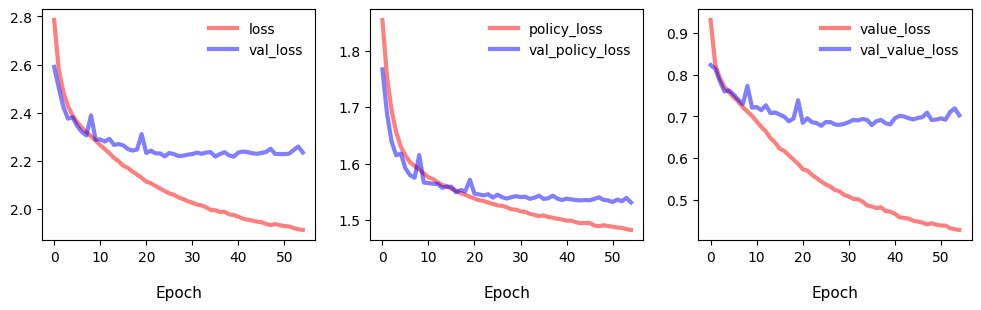

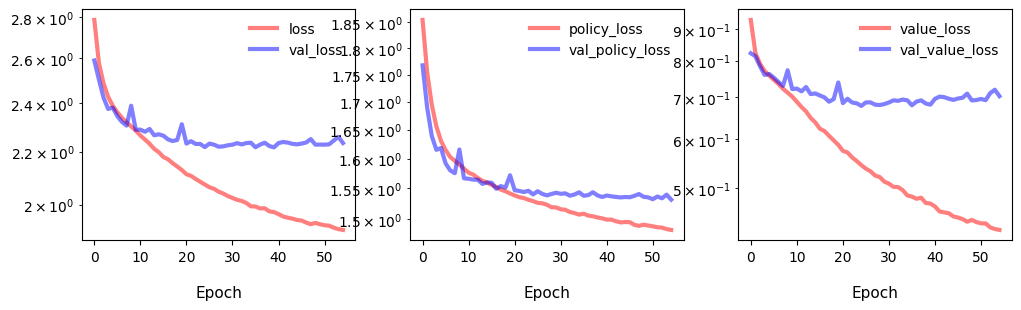

Evaluating model
Evaluating model ../models/test_run/neural_model_v3.h5
Generated 350 / 350 results [t=405.61s]
Generation complete [t=405.62s] [n=350]
Saving tournament results to file ../data/test_run/eval_data_v3.pickle
Evaluating results
Results (LHS player goes first):
  [VANILLA]  91 - 13 - 82  [NEW MODEL]
[NEW MODEL]  111 - 4 - 49  [VANILLA]
Using old model: ../models/test_run/neural_model_v3.h5
Using new model: ../models/test_run/neural_model_v4.h5
Using data file: ../data/test_run/training_data_v4.pickle
Generating data
Generating 3500 games with base seed 1674582193
Using duration = 0.300
Using discount = 0.990
Generated 3500 / 3500 results [t=2836.28s]
Generation complete [t=2836.28s] [n=3500]
Generated 62021 datapoints with average of 17.7 turns per game
model_in with shape: (62021, 7, 6, 1)
model_p  with shape: (62021, 7)
model_v  with shape: (62021, 1)
Saving data to file: ../data/test_run/training_data_v4.pickle
Pre-processing and splitting data
Created training set of s

                                                                                                  
 dense3_dropout (Dropout)       (None, 200)          0           ['dense3_batchnorm[0][0]']       
                                                                                                  
 dense4_feedforward (Dense)     (None, 200)          40200       ['dense3_dropout[0][0]']         
                                                                                                  
 dense4_batchnorm (BatchNormali  (None, 200)         800         ['dense4_feedforward[0][0]']     
 zation)                                                                                          
                                                                                                  
 dense4_dropout (Dropout)       (None, 200)          0           ['dense4_batchnorm[0][0]']       
                                                                                                  
 policy_pr

2023-01-24 18:30:31.831788: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


435/435 [==============================] - 19s 40ms/step - loss: 2.7154 - policy_loss: 1.7865 - value_loss: 0.9289 - val_loss: 2.5382 - val_policy_loss: 1.6948 - val_value_loss: 0.8434
Epoch 2/1000
435/435 [==============================] - 18s 41ms/step - loss: 2.5043 - policy_loss: 1.6783 - value_loss: 0.8261 - val_loss: 2.4258 - val_policy_loss: 1.6189 - val_value_loss: 0.8069
Epoch 3/1000
435/435 [==============================] - 20s 46ms/step - loss: 2.4155 - policy_loss: 1.6215 - value_loss: 0.7940 - val_loss: 2.3642 - val_policy_loss: 1.5786 - val_value_loss: 0.7855
Epoch 4/1000
435/435 [==============================] - 22s 50ms/step - loss: 2.3605 - policy_loss: 1.5834 - value_loss: 0.7771 - val_loss: 2.3246 - val_policy_loss: 1.5489 - val_value_loss: 0.7757
Epoch 5/1000
435/435 [==============================] - 20s 47ms/step - loss: 2.3285 - policy_loss: 1.5616 - value_loss: 0.7669 - val_loss: 2.3016 - val_policy_loss: 1.5346 - val_value_loss: 0.7670
Epoch 6/1000
435/435 [=

435/435 [==============================] - 21s 48ms/step - loss: 1.8941 - policy_loss: 1.4276 - value_loss: 0.4665 - val_loss: 2.1829 - val_policy_loss: 1.4716 - val_value_loss: 0.7113
Epoch 43/1000
435/435 [==============================] - 19s 44ms/step - loss: 1.8881 - policy_loss: 1.4271 - value_loss: 0.4611 - val_loss: 2.1813 - val_policy_loss: 1.4701 - val_value_loss: 0.7112
Epoch 44/1000
435/435 [==============================] - 21s 48ms/step - loss: 1.8883 - policy_loss: 1.4253 - value_loss: 0.4630 - val_loss: 2.1855 - val_policy_loss: 1.4698 - val_value_loss: 0.7158
Epoch 45/1000
435/435 [==============================] - 22s 51ms/step - loss: 1.8789 - policy_loss: 1.4240 - value_loss: 0.4548 - val_loss: 2.1764 - val_policy_loss: 1.4695 - val_value_loss: 0.7069
Epoch 46/1000
435/435 [==============================] - 21s 48ms/step - loss: 1.8831 - policy_loss: 1.4263 - value_loss: 0.4568 - val_loss: 2.1793 - val_policy_loss: 1.4707 - val_value_loss: 0.7086
Epoch 47/1000
435/4

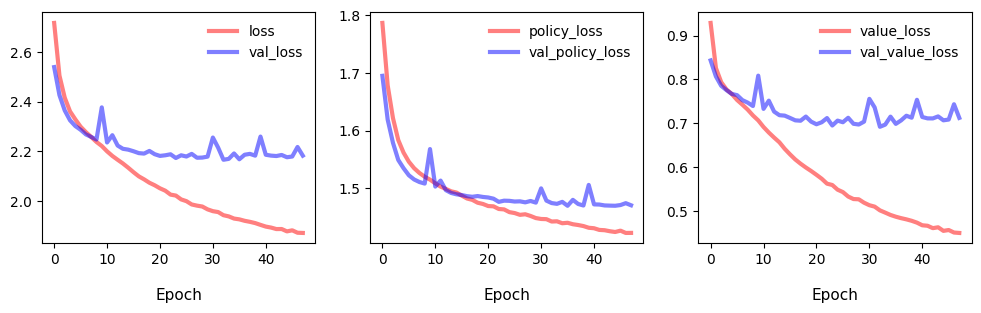

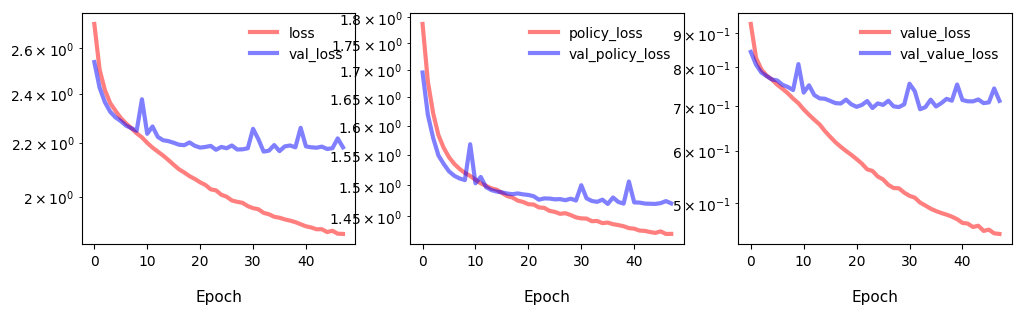

Evaluating model
Evaluating model ../models/test_run/neural_model_v4.h5
Generated 350 / 350 results [t=387.94s]
Generation complete [t=387.94s] [n=350]
Saving tournament results to file ../data/test_run/eval_data_v4.pickle
Evaluating results
Results (LHS player goes first):
  [VANILLA]  74 - 12 - 87  [NEW MODEL]
[NEW MODEL]  109 - 2 - 66  [VANILLA]
Using old model: ../models/test_run/neural_model_v4.h5
Using new model: ../models/test_run/neural_model_v5.h5
Using data file: ../data/test_run/training_data_v5.pickle
Generating data
Generating 3500 games with base seed 1674586423
Using duration = 0.300
Using discount = 0.990
Generated 3500 / 3500 results [t=2789.23s]
Generation complete [t=2789.23s] [n=3500]
Generated 60719 datapoints with average of 17.3 turns per game
model_in with shape: (60719, 7, 6, 1)
model_p  with shape: (60719, 7)
model_v  with shape: (60719, 1)
Saving data to file: ../data/test_run/training_data_v5.pickle
Pre-processing and splitting data
Created training set of s

                                                                                                  
 dense3_dropout (Dropout)       (None, 200)          0           ['dense3_batchnorm[0][0]']       
                                                                                                  
 dense4_feedforward (Dense)     (None, 200)          40200       ['dense3_dropout[0][0]']         
                                                                                                  
 dense4_batchnorm (BatchNormali  (None, 200)         800         ['dense4_feedforward[0][0]']     
 zation)                                                                                          
                                                                                                  
 dense4_dropout (Dropout)       (None, 200)          0           ['dense4_batchnorm[0][0]']       
                                                                                                  
 policy_pr

2023-01-24 19:40:14.938947: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


426/426 [==============================] - 17s 35ms/step - loss: 2.7168 - policy_loss: 1.7785 - value_loss: 0.9383 - val_loss: 2.5431 - val_policy_loss: 1.6984 - val_value_loss: 0.8447
Epoch 2/1000
426/426 [==============================] - 15s 36ms/step - loss: 2.5185 - policy_loss: 1.6865 - value_loss: 0.8320 - val_loss: 2.4415 - val_policy_loss: 1.6178 - val_value_loss: 0.8236
Epoch 3/1000
426/426 [==============================] - 16s 37ms/step - loss: 2.4389 - policy_loss: 1.6390 - value_loss: 0.7999 - val_loss: 2.3564 - val_policy_loss: 1.5696 - val_value_loss: 0.7868
Epoch 4/1000
426/426 [==============================] - 16s 38ms/step - loss: 2.3724 - policy_loss: 1.5923 - value_loss: 0.7801 - val_loss: 2.3069 - val_policy_loss: 1.5375 - val_value_loss: 0.7694
Epoch 5/1000
426/426 [==============================] - 16s 37ms/step - loss: 2.3489 - policy_loss: 1.5783 - value_loss: 0.7707 - val_loss: 2.2846 - val_policy_loss: 1.5168 - val_value_loss: 0.7678
Epoch 6/1000
426/426 [=

426/426 [==============================] - 16s 37ms/step - loss: 1.9388 - policy_loss: 1.4248 - value_loss: 0.5140 - val_loss: 2.1182 - val_policy_loss: 1.4279 - val_value_loss: 0.6903
Epoch 43/1000
426/426 [==============================] - 16s 38ms/step - loss: 1.9428 - policy_loss: 1.4254 - value_loss: 0.5174 - val_loss: 2.1060 - val_policy_loss: 1.4270 - val_value_loss: 0.6790
Epoch 44/1000
426/426 [==============================] - 15s 36ms/step - loss: 1.9370 - policy_loss: 1.4226 - value_loss: 0.5144 - val_loss: 2.1080 - val_policy_loss: 1.4292 - val_value_loss: 0.6787
Epoch 45/1000
426/426 [==============================] - 15s 35ms/step - loss: 1.9384 - policy_loss: 1.4230 - value_loss: 0.5154 - val_loss: 2.1084 - val_policy_loss: 1.4274 - val_value_loss: 0.6810
Epoch 46/1000
426/426 [==============================] - 16s 37ms/step - loss: 1.9273 - policy_loss: 1.4220 - value_loss: 0.5052 - val_loss: 2.1081 - val_policy_loss: 1.4286 - val_value_loss: 0.6795
Epoch 47/1000
426/4

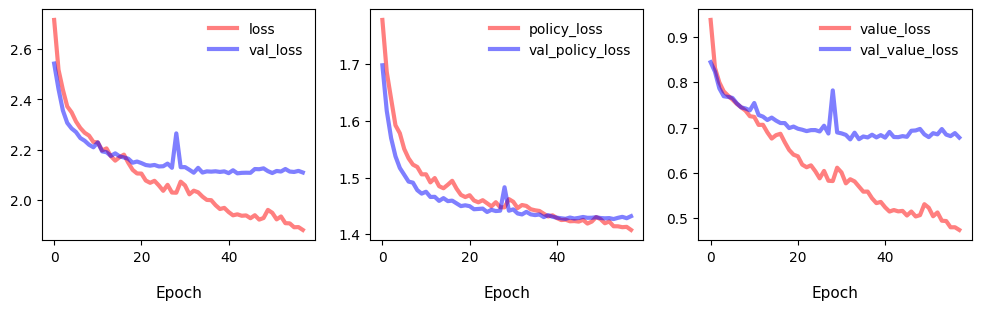

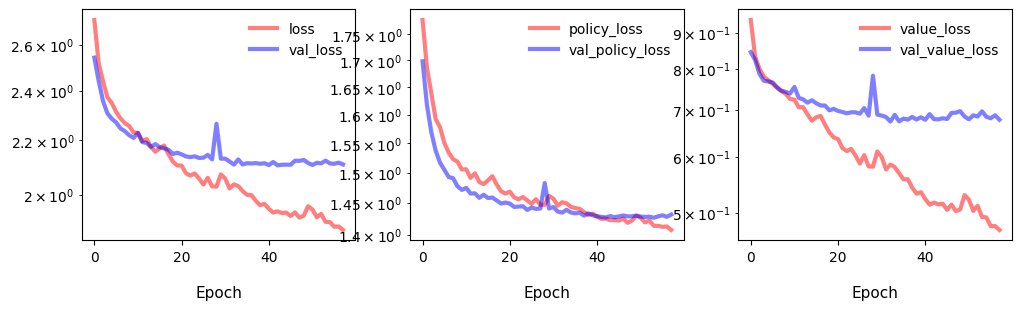

Evaluating model
Evaluating model ../models/test_run/neural_model_v5.h5
Generated 350 / 350 results [t=411.98s]
Generation complete [t=411.99s] [n=350]
Saving tournament results to file ../data/test_run/eval_data_v5.pickle
Evaluating results
Results (LHS player goes first):
  [VANILLA]  75 - 7 - 82  [NEW MODEL]
[NEW MODEL]  126 - 3 - 57  [VANILLA]
Using old model: ../models/test_run/neural_model_v5.h5
Using new model: ../models/test_run/neural_model_v6.h5
Using data file: ../data/test_run/training_data_v6.pickle
Generating data
Generating 3500 games with base seed 1674590543
Using duration = 0.300
Using discount = 0.990
Generated 3500 / 3500 results [t=2751.54s]
Generation complete [t=2751.54s] [n=3500]
Generated 60750 datapoints with average of 17.4 turns per game
model_in with shape: (60750, 7, 6, 1)
model_p  with shape: (60750, 7)
model_v  with shape: (60750, 1)
Saving data to file: ../data/test_run/training_data_v6.pickle
Pre-processing and splitting data
Created training set of si

                                                                                                  
 dense3_dropout (Dropout)       (None, 200)          0           ['dense3_batchnorm[0][0]']       
                                                                                                  
 dense4_feedforward (Dense)     (None, 200)          40200       ['dense3_dropout[0][0]']         
                                                                                                  
 dense4_batchnorm (BatchNormali  (None, 200)         800         ['dense4_feedforward[0][0]']     
 zation)                                                                                          
                                                                                                  
 dense4_dropout (Dropout)       (None, 200)          0           ['dense4_batchnorm[0][0]']       
                                                                                                  
 policy_pr

2023-01-24 20:48:17.350649: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


426/426 [==============================] - 18s 38ms/step - loss: 2.6772 - policy_loss: 1.7431 - value_loss: 0.9341 - val_loss: 2.4647 - val_policy_loss: 1.6331 - val_value_loss: 0.8316
Epoch 2/1000
426/426 [==============================] - 18s 42ms/step - loss: 2.4532 - policy_loss: 1.6270 - value_loss: 0.8261 - val_loss: 2.3568 - val_policy_loss: 1.5505 - val_value_loss: 0.8063
Epoch 3/1000
426/426 [==============================] - 19s 45ms/step - loss: 2.3507 - policy_loss: 1.5585 - value_loss: 0.7921 - val_loss: 2.2866 - val_policy_loss: 1.4962 - val_value_loss: 0.7904
Epoch 4/1000
426/426 [==============================] - 18s 43ms/step - loss: 2.2888 - policy_loss: 1.5171 - value_loss: 0.7718 - val_loss: 2.2494 - val_policy_loss: 1.4734 - val_value_loss: 0.7760
Epoch 5/1000
426/426 [==============================] - 18s 43ms/step - loss: 2.2487 - policy_loss: 1.4905 - value_loss: 0.7582 - val_loss: 2.2042 - val_policy_loss: 1.4422 - val_value_loss: 0.7620
Epoch 6/1000
426/426 [=

426/426 [==============================] - 19s 46ms/step - loss: 1.8130 - policy_loss: 1.3534 - value_loss: 0.4596 - val_loss: 2.0926 - val_policy_loss: 1.3844 - val_value_loss: 0.7082
Epoch 43/1000
426/426 [==============================] - 19s 44ms/step - loss: 1.8054 - policy_loss: 1.3522 - value_loss: 0.4531 - val_loss: 2.0939 - val_policy_loss: 1.3810 - val_value_loss: 0.7129
Epoch 44/1000
426/426 [==============================] - 19s 44ms/step - loss: 1.8021 - policy_loss: 1.3502 - value_loss: 0.4519 - val_loss: 2.0916 - val_policy_loss: 1.3792 - val_value_loss: 0.7124
Saving model to file ../models/test_run/neural_model_v6.h5
Showing training curves


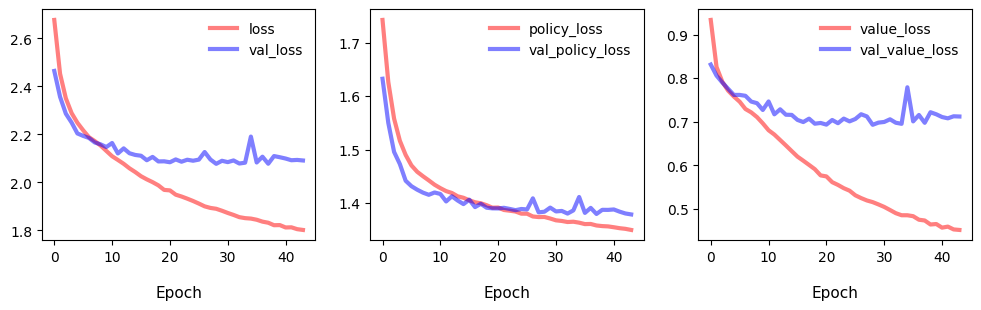

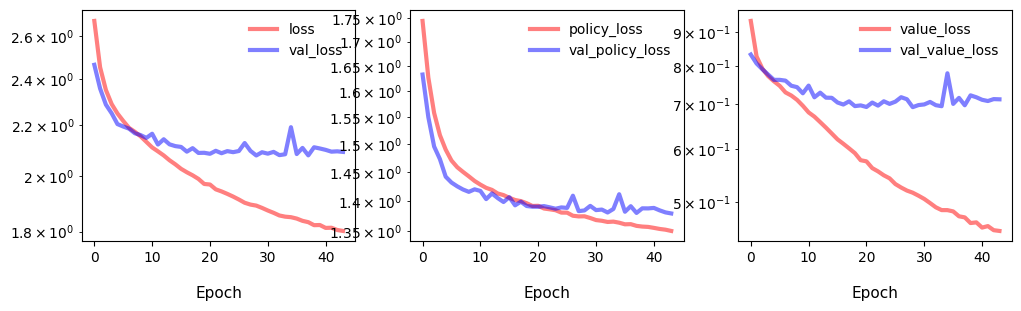

Evaluating model
Evaluating model ../models/test_run/neural_model_v6.h5
Generated 350 / 350 results [t=412.04s]
Generation complete [t=412.04s] [n=350]
Saving tournament results to file ../data/test_run/eval_data_v6.pickle
Evaluating results
Results (LHS player goes first):
  [VANILLA]  82 - 13 - 89  [NEW MODEL]
[NEW MODEL]  100 - 1 - 65  [VANILLA]
Using old model: ../models/test_run/neural_model_v6.h5
Using new model: ../models/test_run/neural_model_v7.h5
Using data file: ../data/test_run/training_data_v7.pickle
Generating data
Generating 3500 games with base seed 1674594601
Using duration = 0.300
Using discount = 0.990
Generated 3500 / 3500 results [t=2853.94s]
Generation complete [t=2853.95s] [n=3500]
Generated 62434 datapoints with average of 17.8 turns per game
model_in with shape: (62434, 7, 6, 1)
model_p  with shape: (62434, 7)
model_v  with shape: (62434, 1)
Saving data to file: ../data/test_run/training_data_v7.pickle
Pre-processing and splitting data
Created training set of s

                                                                                                  
 dense3_dropout (Dropout)       (None, 200)          0           ['dense3_batchnorm[0][0]']       
                                                                                                  
 dense4_feedforward (Dense)     (None, 200)          40200       ['dense3_dropout[0][0]']         
                                                                                                  
 dense4_batchnorm (BatchNormali  (None, 200)         800         ['dense4_feedforward[0][0]']     
 zation)                                                                                          
                                                                                                  
 dense4_dropout (Dropout)       (None, 200)          0           ['dense4_batchnorm[0][0]']       
                                                                                                  
 policy_pr

2023-01-24 21:57:37.770498: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


438/438 [==============================] - 18s 37ms/step - loss: 2.6566 - policy_loss: 1.7344 - value_loss: 0.9223 - val_loss: 2.4748 - val_policy_loss: 1.6442 - val_value_loss: 0.8306
Epoch 2/1000
438/438 [==============================] - 16s 37ms/step - loss: 2.4362 - policy_loss: 1.6203 - value_loss: 0.8160 - val_loss: 2.3424 - val_policy_loss: 1.5550 - val_value_loss: 0.7874
Epoch 3/1000
438/438 [==============================] - 17s 40ms/step - loss: 2.3400 - policy_loss: 1.5552 - value_loss: 0.7848 - val_loss: 2.2747 - val_policy_loss: 1.5009 - val_value_loss: 0.7738
Epoch 4/1000
438/438 [==============================] - 18s 41ms/step - loss: 2.3153 - policy_loss: 1.5389 - value_loss: 0.7765 - val_loss: 2.2495 - val_policy_loss: 1.4802 - val_value_loss: 0.7693
Epoch 5/1000
438/438 [==============================] - 18s 41ms/step - loss: 2.2812 - policy_loss: 1.5130 - value_loss: 0.7682 - val_loss: 2.2313 - val_policy_loss: 1.4651 - val_value_loss: 0.7662
Epoch 6/1000
438/438 [=

438/438 [==============================] - 20s 45ms/step - loss: 1.9198 - policy_loss: 1.3679 - value_loss: 0.5518 - val_loss: 2.0879 - val_policy_loss: 1.3797 - val_value_loss: 0.7082
Epoch 43/1000
438/438 [==============================] - 21s 49ms/step - loss: 1.9070 - policy_loss: 1.3650 - value_loss: 0.5420 - val_loss: 2.0781 - val_policy_loss: 1.3766 - val_value_loss: 0.7015
Epoch 44/1000
438/438 [==============================] - 21s 47ms/step - loss: 1.8936 - policy_loss: 1.3617 - value_loss: 0.5319 - val_loss: 2.0764 - val_policy_loss: 1.3791 - val_value_loss: 0.6972
Epoch 45/1000
438/438 [==============================] - 21s 49ms/step - loss: 1.8864 - policy_loss: 1.3603 - value_loss: 0.5261 - val_loss: 2.0775 - val_policy_loss: 1.3793 - val_value_loss: 0.6982
Epoch 46/1000
438/438 [==============================] - 19s 44ms/step - loss: 1.8809 - policy_loss: 1.3581 - value_loss: 0.5228 - val_loss: 2.0850 - val_policy_loss: 1.3797 - val_value_loss: 0.7052
Epoch 47/1000
438/4

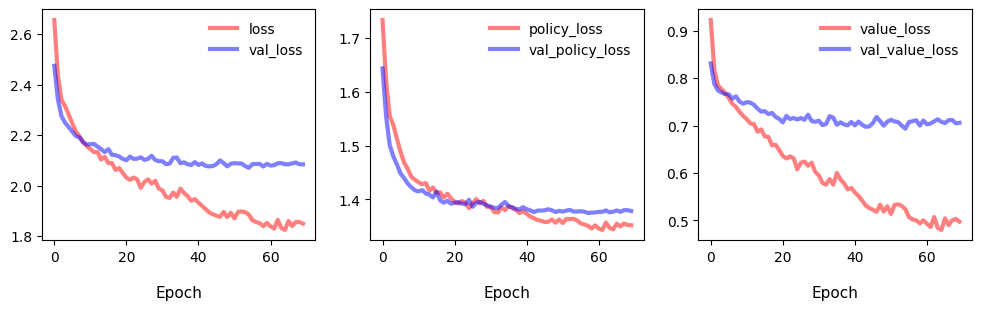

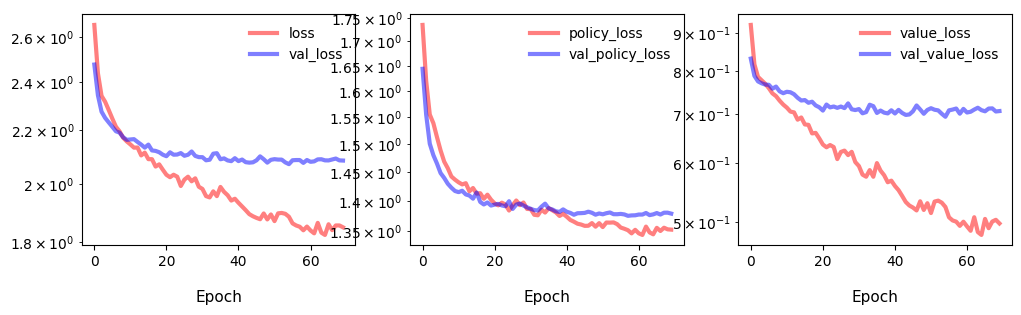

Evaluating model
Evaluating model ../models/test_run/neural_model_v7.h5
Generated 350 / 350 results [t=433.08s]
Generation complete [t=433.09s] [n=350]
Saving tournament results to file ../data/test_run/eval_data_v7.pickle
Evaluating results
Results (LHS player goes first):
  [VANILLA]  72 - 17 - 89  [NEW MODEL]
[NEW MODEL]  113 - 5 - 54  [VANILLA]
Using old model: ../models/test_run/neural_model_v7.h5
Using new model: ../models/test_run/neural_model_v8.h5
Using data file: ../data/test_run/training_data_v8.pickle
Generating data
Generating 3500 games with base seed 1674599242
Using duration = 0.300
Using discount = 0.990
Generated 3500 / 3500 results [t=2799.30s]
Generation complete [t=2799.31s] [n=3500]
Generated 61980 datapoints with average of 17.7 turns per game
model_in with shape: (61980, 7, 6, 1)
model_p  with shape: (61980, 7)
model_v  with shape: (61980, 1)
Saving data to file: ../data/test_run/training_data_v8.pickle
Pre-processing and splitting data
Created training set of s

                                                                                                  
 dense3_dropout (Dropout)       (None, 200)          0           ['dense3_batchnorm[0][0]']       
                                                                                                  
 dense4_feedforward (Dense)     (None, 200)          40200       ['dense3_dropout[0][0]']         
                                                                                                  
 dense4_batchnorm (BatchNormali  (None, 200)         800         ['dense4_feedforward[0][0]']     
 zation)                                                                                          
                                                                                                  
 dense4_dropout (Dropout)       (None, 200)          0           ['dense4_batchnorm[0][0]']       
                                                                                                  
 policy_pr

2023-01-24 23:14:04.192340: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


434/434 [==============================] - 19s 39ms/step - loss: 2.6926 - policy_loss: 1.7440 - value_loss: 0.9486 - val_loss: 2.4640 - val_policy_loss: 1.6293 - val_value_loss: 0.8347
Epoch 2/1000
434/434 [==============================] - 19s 43ms/step - loss: 2.4362 - policy_loss: 1.6159 - value_loss: 0.8202 - val_loss: 2.3296 - val_policy_loss: 1.5367 - val_value_loss: 0.7929
Epoch 3/1000
434/434 [==============================] - 21s 48ms/step - loss: 2.3326 - policy_loss: 1.5468 - value_loss: 0.7859 - val_loss: 2.2536 - val_policy_loss: 1.4820 - val_value_loss: 0.7716
Epoch 4/1000
434/434 [==============================] - 20s 46ms/step - loss: 2.2703 - policy_loss: 1.5042 - value_loss: 0.7662 - val_loss: 2.2183 - val_policy_loss: 1.4519 - val_value_loss: 0.7663
Epoch 5/1000
434/434 [==============================] - 21s 49ms/step - loss: 2.2312 - policy_loss: 1.4782 - value_loss: 0.7530 - val_loss: 2.1921 - val_policy_loss: 1.4380 - val_value_loss: 0.7541
Epoch 6/1000
434/434 [=

434/434 [==============================] - 20s 45ms/step - loss: 1.8044 - policy_loss: 1.3430 - value_loss: 0.4614 - val_loss: 2.0864 - val_policy_loss: 1.3742 - val_value_loss: 0.7122
Epoch 43/1000
434/434 [==============================] - 19s 43ms/step - loss: 1.7999 - policy_loss: 1.3422 - value_loss: 0.4576 - val_loss: 2.0726 - val_policy_loss: 1.3761 - val_value_loss: 0.6965
Epoch 44/1000
434/434 [==============================] - 19s 45ms/step - loss: 1.8004 - policy_loss: 1.3422 - value_loss: 0.4582 - val_loss: 2.1005 - val_policy_loss: 1.3933 - val_value_loss: 0.7071
Epoch 45/1000
434/434 [==============================] - 19s 45ms/step - loss: 1.7913 - policy_loss: 1.3388 - value_loss: 0.4525 - val_loss: 2.0749 - val_policy_loss: 1.3727 - val_value_loss: 0.7022
Epoch 46/1000
434/434 [==============================] - 21s 49ms/step - loss: 1.7869 - policy_loss: 1.3388 - value_loss: 0.4482 - val_loss: 2.0713 - val_policy_loss: 1.3737 - val_value_loss: 0.6976
Epoch 47/1000
434/4

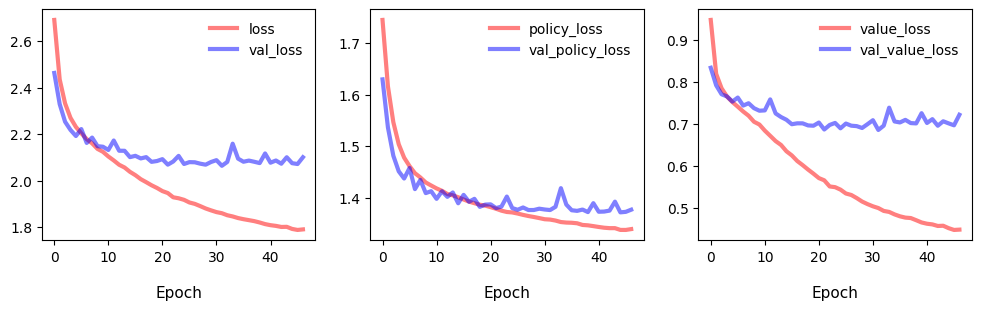

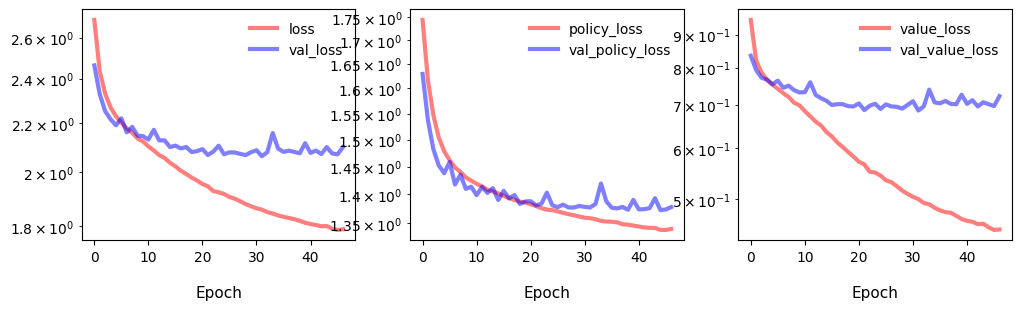

Evaluating model
Evaluating model ../models/test_run/neural_model_v8.h5
Generated 350 / 350 results [t=415.10s]
Generation complete [t=415.10s] [n=350]
Saving tournament results to file ../data/test_run/eval_data_v8.pickle
Evaluating results
Results (LHS player goes first):
  [VANILLA]  72 - 14 - 90  [NEW MODEL]
[NEW MODEL]  115 - 2 - 57  [VANILLA]
Using old model: ../models/test_run/neural_model_v8.h5
Using new model: ../models/test_run/neural_model_v9.h5
Using data file: ../data/test_run/training_data_v9.pickle
Generating data
Generating 3500 games with base seed 1674603432
Using duration = 0.300
Using discount = 0.990
Generated 3500 / 3500 results [t=2757.82s]
Generation complete [t=2757.82s] [n=3500]
Generated 60838 datapoints with average of 17.4 turns per game
model_in with shape: (60838, 7, 6, 1)
model_p  with shape: (60838, 7)
model_v  with shape: (60838, 1)
Saving data to file: ../data/test_run/training_data_v9.pickle
Pre-processing and splitting data
Created training set of s

                                                                                                  
 dense3_dropout (Dropout)       (None, 200)          0           ['dense3_batchnorm[0][0]']       
                                                                                                  
 dense4_feedforward (Dense)     (None, 200)          40200       ['dense3_dropout[0][0]']         
                                                                                                  
 dense4_batchnorm (BatchNormali  (None, 200)         800         ['dense4_feedforward[0][0]']     
 zation)                                                                                          
                                                                                                  
 dense4_dropout (Dropout)       (None, 200)          0           ['dense4_batchnorm[0][0]']       
                                                                                                  
 policy_pr

2023-01-25 00:23:12.888897: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


426/426 [==============================] - 17s 36ms/step - loss: 2.6945 - policy_loss: 1.7451 - value_loss: 0.9494 - val_loss: 2.5125 - val_policy_loss: 1.6470 - val_value_loss: 0.8655
Epoch 2/1000
426/426 [==============================] - 16s 38ms/step - loss: 2.4637 - policy_loss: 1.6270 - value_loss: 0.8367 - val_loss: 2.3497 - val_policy_loss: 1.5510 - val_value_loss: 0.7987
Epoch 3/1000
426/426 [==============================] - 18s 43ms/step - loss: 2.3626 - policy_loss: 1.5630 - value_loss: 0.7995 - val_loss: 2.2946 - val_policy_loss: 1.5034 - val_value_loss: 0.7912
Epoch 4/1000
426/426 [==============================] - 18s 43ms/step - loss: 2.2986 - policy_loss: 1.5171 - value_loss: 0.7815 - val_loss: 2.2537 - val_policy_loss: 1.4704 - val_value_loss: 0.7833
Epoch 5/1000
426/426 [==============================] - 17s 41ms/step - loss: 2.2551 - policy_loss: 1.4885 - value_loss: 0.7666 - val_loss: 2.2179 - val_policy_loss: 1.4486 - val_value_loss: 0.7692
Epoch 6/1000
426/426 [=

426/426 [==============================] - 19s 44ms/step - loss: 1.8161 - policy_loss: 1.3468 - value_loss: 0.4693 - val_loss: 2.1159 - val_policy_loss: 1.3743 - val_value_loss: 0.7416
Epoch 43/1000
426/426 [==============================] - 20s 46ms/step - loss: 1.8124 - policy_loss: 1.3466 - value_loss: 0.4658 - val_loss: 2.0911 - val_policy_loss: 1.3727 - val_value_loss: 0.7183
Epoch 44/1000
426/426 [==============================] - 21s 49ms/step - loss: 1.8038 - policy_loss: 1.3451 - value_loss: 0.4587 - val_loss: 2.2261 - val_policy_loss: 1.4202 - val_value_loss: 0.8060
Epoch 45/1000
426/426 [==============================] - 20s 48ms/step - loss: 1.8011 - policy_loss: 1.3441 - value_loss: 0.4570 - val_loss: 2.1089 - val_policy_loss: 1.3753 - val_value_loss: 0.7336
Epoch 46/1000
426/426 [==============================] - 21s 49ms/step - loss: 1.7959 - policy_loss: 1.3426 - value_loss: 0.4533 - val_loss: 2.0922 - val_policy_loss: 1.3723 - val_value_loss: 0.7199
Epoch 47/1000
426/4

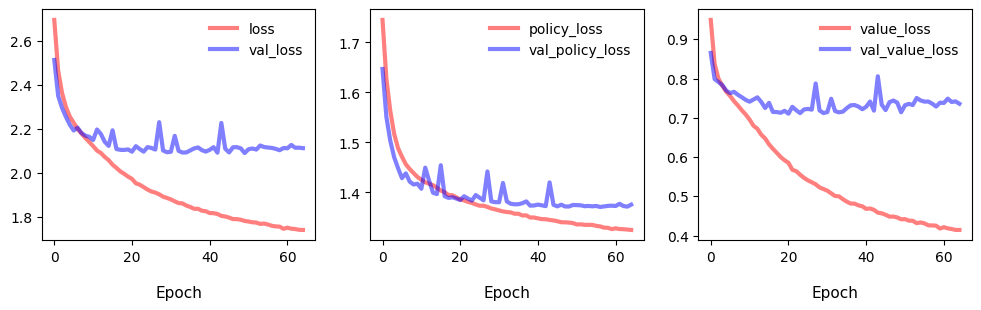

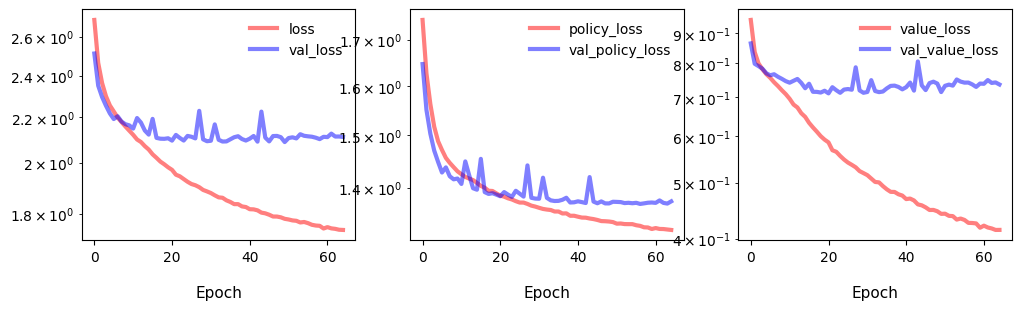

Evaluating model
Evaluating model ../models/test_run/neural_model_v9.h5
Generated 350 / 350 results [t=369.91s]
Generation complete [t=369.91s] [n=350]
Saving tournament results to file ../data/test_run/eval_data_v9.pickle
Evaluating results
Results (LHS player goes first):
  [VANILLA]  94 - 9 - 95  [NEW MODEL]
[NEW MODEL]  97 - 4 - 51  [VANILLA]
Using old model: ../models/test_run/neural_model_v9.h5
Using new model: ../models/test_run/neural_model_v10.h5
Using data file: ../data/test_run/training_data_v10.pickle
Generating data
Generating 3500 games with base seed 1674607889
Using duration = 0.300
Using discount = 0.990
Generated 3500 / 3500 results [t=2770.00s]
Generation complete [t=2770.00s] [n=3500]
Generated 60950 datapoints with average of 17.4 turns per game
model_in with shape: (60950, 7, 6, 1)
model_p  with shape: (60950, 7)
model_v  with shape: (60950, 1)
Saving data to file: ../data/test_run/training_data_v10.pickle
Pre-processing and splitting data
Created training set of 

                                                                                                  
 dense3_dropout (Dropout)       (None, 200)          0           ['dense3_batchnorm[0][0]']       
                                                                                                  
 dense4_feedforward (Dense)     (None, 200)          40200       ['dense3_dropout[0][0]']         
                                                                                                  
 dense4_batchnorm (BatchNormali  (None, 200)         800         ['dense4_feedforward[0][0]']     
 zation)                                                                                          
                                                                                                  
 dense4_dropout (Dropout)       (None, 200)          0           ['dense4_batchnorm[0][0]']       
                                                                                                  
 policy_pr

2023-01-25 01:37:41.679318: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


427/427 [==============================] - 18s 38ms/step - loss: 2.6896 - policy_loss: 1.7473 - value_loss: 0.9423 - val_loss: 2.4385 - val_policy_loss: 1.6320 - val_value_loss: 0.8066
Epoch 2/1000
427/427 [==============================] - 18s 41ms/step - loss: 2.4481 - policy_loss: 1.6248 - value_loss: 0.8233 - val_loss: 2.3523 - val_policy_loss: 1.5429 - val_value_loss: 0.8094
Epoch 3/1000
427/427 [==============================] - 21s 50ms/step - loss: 2.3520 - policy_loss: 1.5604 - value_loss: 0.7916 - val_loss: 2.2798 - val_policy_loss: 1.5007 - val_value_loss: 0.7791
Epoch 4/1000
427/427 [==============================] - 20s 48ms/step - loss: 2.2945 - policy_loss: 1.5214 - value_loss: 0.7731 - val_loss: 2.2420 - val_policy_loss: 1.4627 - val_value_loss: 0.7793
Epoch 5/1000
427/427 [==============================] - 20s 46ms/step - loss: 2.2552 - policy_loss: 1.4955 - value_loss: 0.7597 - val_loss: 2.2072 - val_policy_loss: 1.4476 - val_value_loss: 0.7595
Epoch 6/1000
427/427 [=

427/427 [==============================] - 21s 49ms/step - loss: 1.8189 - policy_loss: 1.3523 - value_loss: 0.4666 - val_loss: 2.1000 - val_policy_loss: 1.3824 - val_value_loss: 0.7176
Epoch 43/1000
427/427 [==============================] - 22s 50ms/step - loss: 1.8128 - policy_loss: 1.3503 - value_loss: 0.4625 - val_loss: 2.0869 - val_policy_loss: 1.3829 - val_value_loss: 0.7040
Epoch 44/1000
427/427 [==============================] - 20s 47ms/step - loss: 1.8134 - policy_loss: 1.3496 - value_loss: 0.4638 - val_loss: 2.0883 - val_policy_loss: 1.3834 - val_value_loss: 0.7049
Epoch 45/1000
427/427 [==============================] - 21s 48ms/step - loss: 1.8055 - policy_loss: 1.3474 - value_loss: 0.4581 - val_loss: 2.1083 - val_policy_loss: 1.3842 - val_value_loss: 0.7241
Epoch 46/1000
427/427 [==============================] - 22s 50ms/step - loss: 1.8020 - policy_loss: 1.3478 - value_loss: 0.4542 - val_loss: 2.1066 - val_policy_loss: 1.3867 - val_value_loss: 0.7199
Epoch 47/1000
427/4

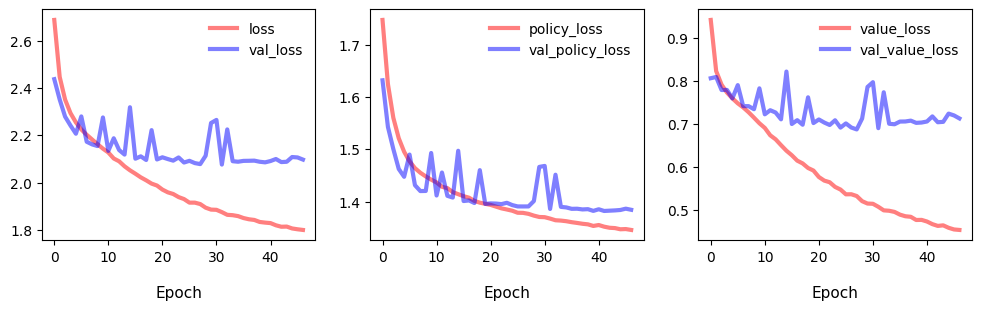

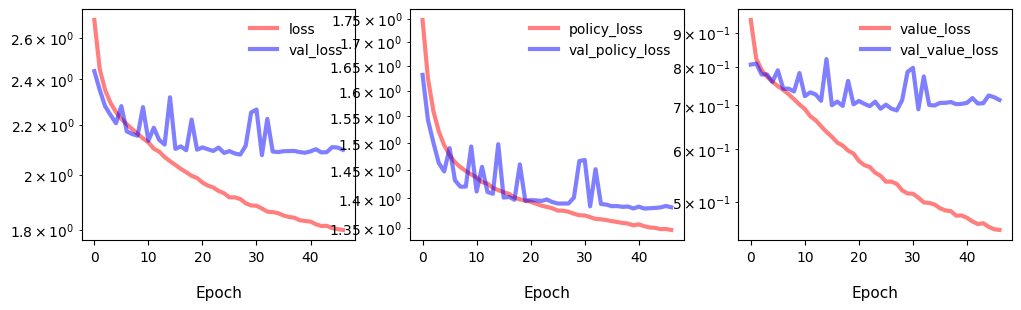

Evaluating model
Evaluating model ../models/test_run/neural_model_v10.h5
Generated 350 / 350 results [t=403.10s]
Generation complete [t=403.10s] [n=350]
Saving tournament results to file ../data/test_run/eval_data_v10.pickle
Evaluating results
Results (LHS player goes first):
  [VANILLA]  85 - 7 - 95  [NEW MODEL]
[NEW MODEL]  109 - 2 - 52  [VANILLA]
Using old model: ../models/test_run/neural_model_v10.h5
Using new model: ../models/test_run/neural_model_v11.h5
Using data file: ../data/test_run/training_data_v11.pickle
Generating data
Generating 3500 games with base seed 1674612034
Using duration = 0.300
Using discount = 0.990
Generated 3500 / 3500 results [t=2854.16s]
Generation complete [t=2854.16s] [n=3500]
Generated 62163 datapoints with average of 17.8 turns per game
model_in with shape: (62163, 7, 6, 1)
model_p  with shape: (62163, 7)
model_v  with shape: (62163, 1)
Saving data to file: ../data/test_run/training_data_v11.pickle
Pre-processing and splitting data
Created training set

                                                                                                  
 dense3_dropout (Dropout)       (None, 200)          0           ['dense3_batchnorm[0][0]']       
                                                                                                  
 dense4_feedforward (Dense)     (None, 200)          40200       ['dense3_dropout[0][0]']         
                                                                                                  
 dense4_batchnorm (BatchNormali  (None, 200)         800         ['dense4_feedforward[0][0]']     
 zation)                                                                                          
                                                                                                  
 dense4_dropout (Dropout)       (None, 200)          0           ['dense4_batchnorm[0][0]']       
                                                                                                  
 policy_pr

2023-01-25 02:48:10.745282: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


436/436 [==============================] - 17s 35ms/step - loss: 2.6616 - policy_loss: 1.7559 - value_loss: 0.9057 - val_loss: 2.4561 - val_policy_loss: 1.6506 - val_value_loss: 0.8054
Epoch 2/1000
436/436 [==============================] - 15s 35ms/step - loss: 2.4482 - policy_loss: 1.6365 - value_loss: 0.8117 - val_loss: 2.3344 - val_policy_loss: 1.5575 - val_value_loss: 0.7769
Epoch 3/1000
436/436 [==============================] - 17s 39ms/step - loss: 2.3466 - policy_loss: 1.5703 - value_loss: 0.7763 - val_loss: 2.2609 - val_policy_loss: 1.5044 - val_value_loss: 0.7565
Epoch 4/1000
436/436 [==============================] - 17s 39ms/step - loss: 2.2841 - policy_loss: 1.5273 - value_loss: 0.7568 - val_loss: 2.2236 - val_policy_loss: 1.4748 - val_value_loss: 0.7488
Epoch 5/1000
436/436 [==============================] - 18s 41ms/step - loss: 2.2443 - policy_loss: 1.5012 - value_loss: 0.7432 - val_loss: 2.2218 - val_policy_loss: 1.4772 - val_value_loss: 0.7446
Epoch 6/1000
436/436 [=

436/436 [==============================] - 20s 46ms/step - loss: 1.8061 - policy_loss: 1.3537 - value_loss: 0.4523 - val_loss: 2.0725 - val_policy_loss: 1.3882 - val_value_loss: 0.6844
Epoch 43/1000
436/436 [==============================] - 20s 47ms/step - loss: 1.8039 - policy_loss: 1.3537 - value_loss: 0.4502 - val_loss: 2.0685 - val_policy_loss: 1.3913 - val_value_loss: 0.6771
Epoch 44/1000
436/436 [==============================] - 21s 47ms/step - loss: 1.8011 - policy_loss: 1.3505 - value_loss: 0.4506 - val_loss: 2.0893 - val_policy_loss: 1.3932 - val_value_loss: 0.6961
Epoch 45/1000
436/436 [==============================] - 21s 47ms/step - loss: 1.7927 - policy_loss: 1.3507 - value_loss: 0.4420 - val_loss: 2.0796 - val_policy_loss: 1.3987 - val_value_loss: 0.6809
Epoch 46/1000
436/436 [==============================] - 20s 46ms/step - loss: 1.7919 - policy_loss: 1.3486 - value_loss: 0.4433 - val_loss: 2.0645 - val_policy_loss: 1.3894 - val_value_loss: 0.6751
Epoch 47/1000
436/4

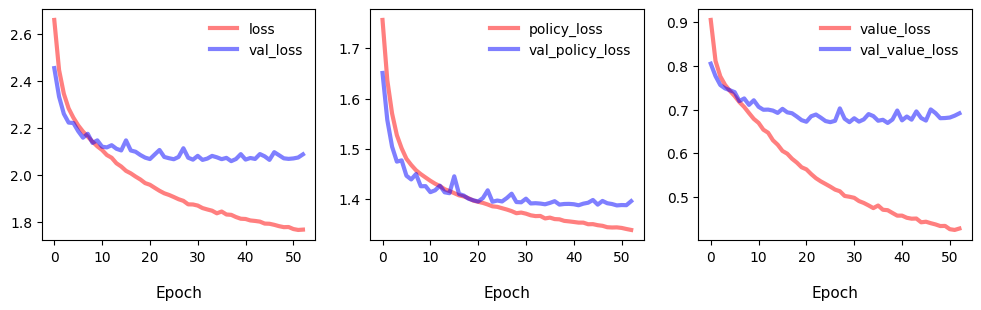

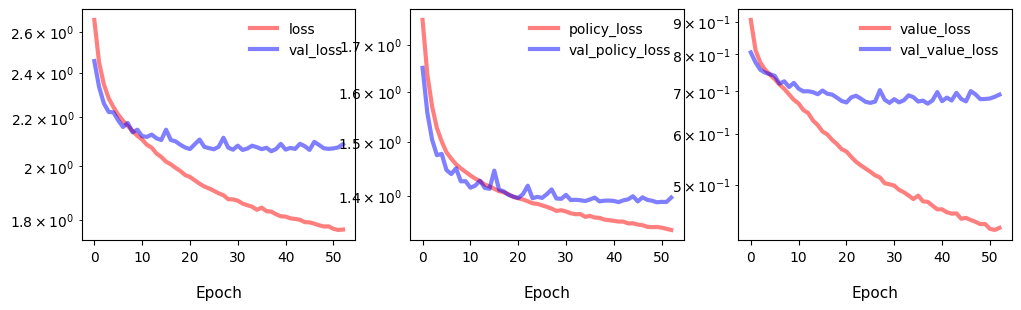

Evaluating model
Evaluating model ../models/test_run/neural_model_v11.h5
Generated 350 / 350 results [t=430.15s]
Generation complete [t=430.15s] [n=350]
Saving tournament results to file ../data/test_run/eval_data_v11.pickle
Evaluating results
Results (LHS player goes first):
  [VANILLA]  86 - 10 - 72  [NEW MODEL]
[NEW MODEL]  120 - 5 - 57  [VANILLA]
Using old model: ../models/test_run/neural_model_v11.h5
Using new model: ../models/test_run/neural_model_v12.h5
Using data file: ../data/test_run/training_data_v12.pickle
Generating data
Generating 3500 games with base seed 1674616359
Using duration = 0.300
Using discount = 0.990
Generated 3500 / 3500 results [t=2896.41s]
Generation complete [t=2896.42s] [n=3500]
Generated 61703 datapoints with average of 17.6 turns per game
model_in with shape: (61703, 7, 6, 1)
model_p  with shape: (61703, 7)
model_v  with shape: (61703, 1)
Saving data to file: ../data/test_run/training_data_v12.pickle
Pre-processing and splitting data
Created training se

                                                                                                  
 dense3_dropout (Dropout)       (None, 200)          0           ['dense3_batchnorm[0][0]']       
                                                                                                  
 dense4_feedforward (Dense)     (None, 200)          40200       ['dense3_dropout[0][0]']         
                                                                                                  
 dense4_batchnorm (BatchNormali  (None, 200)         800         ['dense4_feedforward[0][0]']     
 zation)                                                                                          
                                                                                                  
 dense4_dropout (Dropout)       (None, 200)          0           ['dense4_batchnorm[0][0]']       
                                                                                                  
 policy_pr

2023-01-25 04:00:57.463273: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


432/432 [==============================] - 17s 37ms/step - loss: 2.6523 - policy_loss: 1.7509 - value_loss: 0.9014 - val_loss: 2.4372 - val_policy_loss: 1.6343 - val_value_loss: 0.8029
Epoch 2/1000
432/432 [==============================] - 17s 40ms/step - loss: 2.4254 - policy_loss: 1.6213 - value_loss: 0.8041 - val_loss: 2.3234 - val_policy_loss: 1.5402 - val_value_loss: 0.7832
Epoch 3/1000
432/432 [==============================] - 18s 41ms/step - loss: 2.3259 - policy_loss: 1.5550 - value_loss: 0.7709 - val_loss: 2.2456 - val_policy_loss: 1.4865 - val_value_loss: 0.7591
Epoch 4/1000
432/432 [==============================] - 19s 44ms/step - loss: 2.2690 - policy_loss: 1.5112 - value_loss: 0.7579 - val_loss: 2.2130 - val_policy_loss: 1.4600 - val_value_loss: 0.7529
Epoch 5/1000
432/432 [==============================] - 19s 45ms/step - loss: 2.2264 - policy_loss: 1.4826 - value_loss: 0.7438 - val_loss: 2.2587 - val_policy_loss: 1.5101 - val_value_loss: 0.7486
Epoch 6/1000
432/432 [=

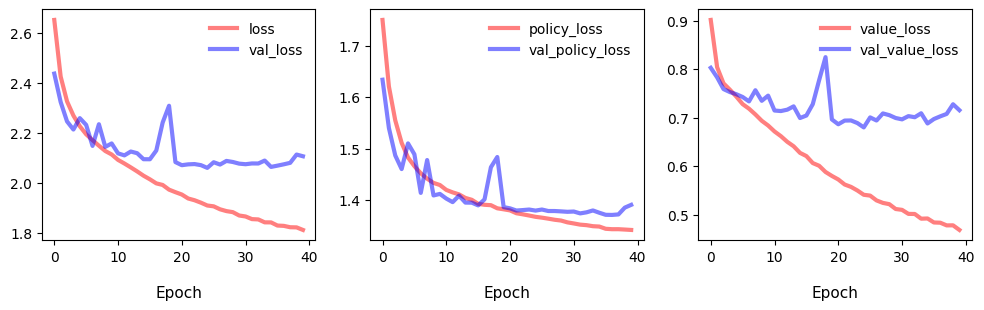

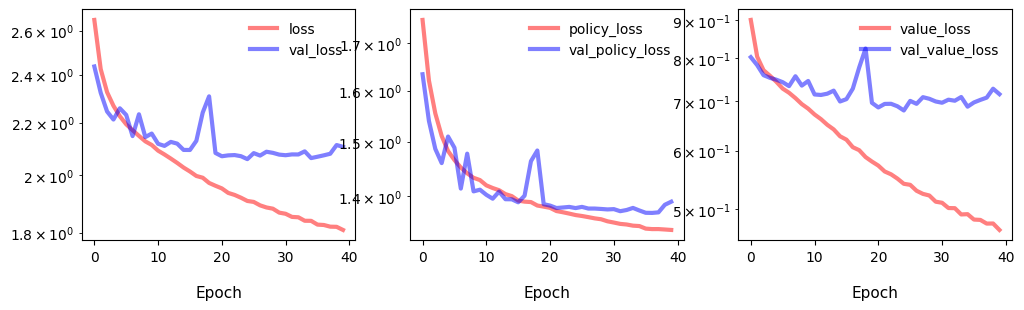

Evaluating model
Evaluating model ../models/test_run/neural_model_v12.h5
Generated 350 / 350 results [t=387.97s]
Generation complete [t=387.97s] [n=350]
Saving tournament results to file ../data/test_run/eval_data_v12.pickle
Evaluating results
Results (LHS player goes first):
  [VANILLA]  71 - 14 - 94  [NEW MODEL]
[NEW MODEL]  118 - 3 - 50  [VANILLA]
Using old model: ../models/test_run/neural_model_v12.h5
Using new model: ../models/test_run/neural_model_v13.h5
Using data file: ../data/test_run/training_data_v13.pickle
Generating data
Generating 3500 games with base seed 1674620406
Using duration = 0.300
Using discount = 0.990
Generated 3500 / 3500 results [t=2775.76s]
Generation complete [t=2775.77s] [n=3500]
Generated 60997 datapoints with average of 17.4 turns per game
model_in with shape: (60997, 7, 6, 1)
model_p  with shape: (60997, 7)
model_v  with shape: (60997, 1)
Saving data to file: ../data/test_run/training_data_v13.pickle
Pre-processing and splitting data
Created training se

                                                                                                  
 dense3_dropout (Dropout)       (None, 200)          0           ['dense3_batchnorm[0][0]']       
                                                                                                  
 dense4_feedforward (Dense)     (None, 200)          40200       ['dense3_dropout[0][0]']         
                                                                                                  
 dense4_batchnorm (BatchNormali  (None, 200)         800         ['dense4_feedforward[0][0]']     
 zation)                                                                                          
                                                                                                  
 dense4_dropout (Dropout)       (None, 200)          0           ['dense4_batchnorm[0][0]']       
                                                                                                  
 policy_pr

2023-01-25 05:06:23.939899: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


427/427 [==============================] - 17s 36ms/step - loss: 2.6561 - policy_loss: 1.7159 - value_loss: 0.9402 - val_loss: 2.4938 - val_policy_loss: 1.6235 - val_value_loss: 0.8703
Epoch 2/1000
427/427 [==============================] - 16s 38ms/step - loss: 2.4292 - policy_loss: 1.5916 - value_loss: 0.8375 - val_loss: 2.3526 - val_policy_loss: 1.5178 - val_value_loss: 0.8348
Epoch 3/1000
427/427 [==============================] - 17s 40ms/step - loss: 2.3264 - policy_loss: 1.5214 - value_loss: 0.8050 - val_loss: 2.2544 - val_policy_loss: 1.4603 - val_value_loss: 0.7941
Epoch 4/1000
427/427 [==============================] - 19s 44ms/step - loss: 2.2640 - policy_loss: 1.4778 - value_loss: 0.7862 - val_loss: 2.2019 - val_policy_loss: 1.4264 - val_value_loss: 0.7756
Epoch 5/1000
427/427 [==============================] - 18s 41ms/step - loss: 2.2219 - policy_loss: 1.4478 - value_loss: 0.7742 - val_loss: 2.1898 - val_policy_loss: 1.4079 - val_value_loss: 0.7820
Epoch 6/1000
427/427 [=

427/427 [==============================] - 21s 49ms/step - loss: 1.7938 - policy_loss: 1.3113 - value_loss: 0.4825 - val_loss: 2.0677 - val_policy_loss: 1.3429 - val_value_loss: 0.7249
Epoch 43/1000
427/427 [==============================] - 22s 50ms/step - loss: 1.7830 - policy_loss: 1.3091 - value_loss: 0.4739 - val_loss: 2.0784 - val_policy_loss: 1.3450 - val_value_loss: 0.7334
Epoch 44/1000
427/427 [==============================] - 23s 53ms/step - loss: 1.7813 - policy_loss: 1.3073 - value_loss: 0.4740 - val_loss: 2.0753 - val_policy_loss: 1.3437 - val_value_loss: 0.7315
Epoch 45/1000
427/427 [==============================] - 23s 53ms/step - loss: 1.7706 - policy_loss: 1.3053 - value_loss: 0.4652 - val_loss: 2.0695 - val_policy_loss: 1.3429 - val_value_loss: 0.7267
Epoch 46/1000
427/427 [==============================] - 23s 54ms/step - loss: 1.7709 - policy_loss: 1.3063 - value_loss: 0.4646 - val_loss: 2.0818 - val_policy_loss: 1.3434 - val_value_loss: 0.7384
Epoch 47/1000
427/4

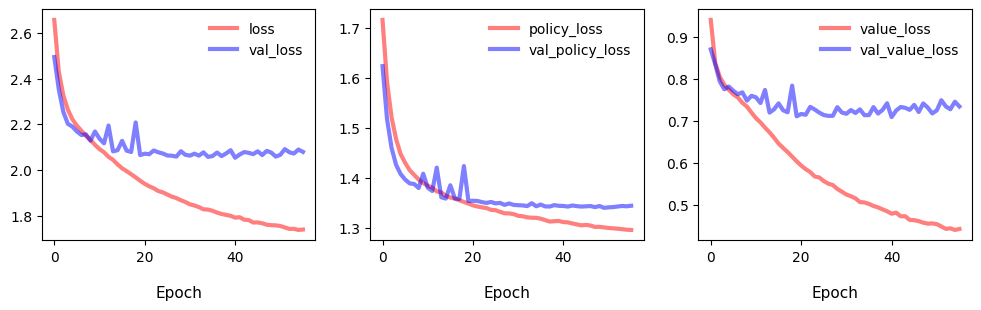

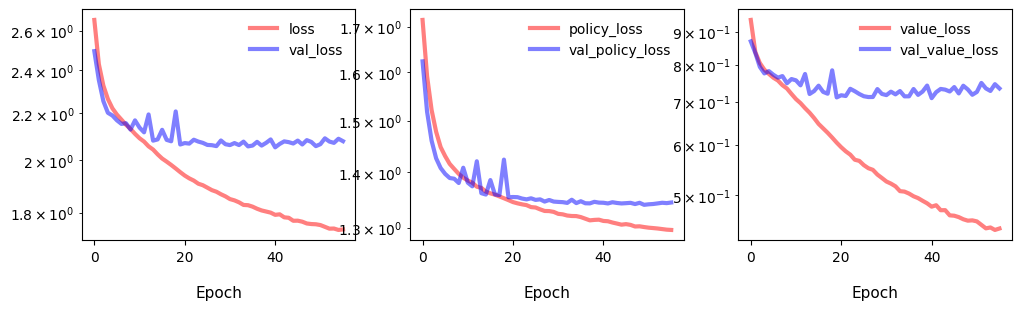

Evaluating model
Evaluating model ../models/test_run/neural_model_v13.h5
Generated 350 / 350 results [t=430.06s]
Generation complete [t=430.06s] [n=350]
Saving tournament results to file ../data/test_run/eval_data_v13.pickle
Evaluating results
Results (LHS player goes first):
  [VANILLA]  86 - 15 - 76  [NEW MODEL]
[NEW MODEL]  117 - 4 - 52  [VANILLA]
Using old model: ../models/test_run/neural_model_v13.h5
Using new model: ../models/test_run/neural_model_v14.h5
Using data file: ../data/test_run/training_data_v14.pickle
Generating data
Generating 3500 games with base seed 1674624768
Using duration = 0.300
Using discount = 0.990
Generated 3500 / 3500 results [t=2820.91s]
Generation complete [t=2820.91s] [n=3500]
Generated 62522 datapoints with average of 17.9 turns per game
model_in with shape: (62522, 7, 6, 1)
model_p  with shape: (62522, 7)
model_v  with shape: (62522, 1)
Saving data to file: ../data/test_run/training_data_v14.pickle
Pre-processing and splitting data
Created training se

                                                                                                  
 dense3_dropout (Dropout)       (None, 200)          0           ['dense3_batchnorm[0][0]']       
                                                                                                  
 dense4_feedforward (Dense)     (None, 200)          40200       ['dense3_dropout[0][0]']         
                                                                                                  
 dense4_batchnorm (BatchNormali  (None, 200)         800         ['dense4_feedforward[0][0]']     
 zation)                                                                                          
                                                                                                  
 dense4_dropout (Dropout)       (None, 200)          0           ['dense4_batchnorm[0][0]']       
                                                                                                  
 policy_pr

2023-01-25 06:19:51.190757: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


438/438 [==============================] - 18s 37ms/step - loss: 2.6375 - policy_loss: 1.7373 - value_loss: 0.9002 - val_loss: 2.4564 - val_policy_loss: 1.6352 - val_value_loss: 0.8212
Epoch 2/1000
438/438 [==============================] - 17s 39ms/step - loss: 2.4231 - policy_loss: 1.6191 - value_loss: 0.8040 - val_loss: 2.3091 - val_policy_loss: 1.5355 - val_value_loss: 0.7736
Epoch 3/1000
438/438 [==============================] - 18s 40ms/step - loss: 2.3255 - policy_loss: 1.5511 - value_loss: 0.7744 - val_loss: 2.2394 - val_policy_loss: 1.4783 - val_value_loss: 0.7611
Epoch 4/1000
438/438 [==============================] - 20s 45ms/step - loss: 2.2605 - policy_loss: 1.5054 - value_loss: 0.7551 - val_loss: 2.2135 - val_policy_loss: 1.4556 - val_value_loss: 0.7579
Epoch 5/1000
438/438 [==============================] - 19s 44ms/step - loss: 2.2247 - policy_loss: 1.4814 - value_loss: 0.7433 - val_loss: 2.1920 - val_policy_loss: 1.4381 - val_value_loss: 0.7539
Epoch 6/1000
438/438 [=

438/438 [==============================] - 22s 50ms/step - loss: 1.7916 - policy_loss: 1.3360 - value_loss: 0.4556 - val_loss: 2.0642 - val_policy_loss: 1.3721 - val_value_loss: 0.6922
Epoch 43/1000
438/438 [==============================] - 22s 51ms/step - loss: 1.7867 - policy_loss: 1.3382 - value_loss: 0.4484 - val_loss: 2.0804 - val_policy_loss: 1.3731 - val_value_loss: 0.7072
Epoch 44/1000
438/438 [==============================] - 21s 49ms/step - loss: 1.7793 - policy_loss: 1.3346 - value_loss: 0.4448 - val_loss: 2.0766 - val_policy_loss: 1.3743 - val_value_loss: 0.7023
Epoch 45/1000
438/438 [==============================] - 22s 51ms/step - loss: 1.7768 - policy_loss: 1.3346 - value_loss: 0.4422 - val_loss: 2.0892 - val_policy_loss: 1.3783 - val_value_loss: 0.7110
Epoch 46/1000
438/438 [==============================] - 19s 44ms/step - loss: 1.7719 - policy_loss: 1.3322 - value_loss: 0.4397 - val_loss: 2.1027 - val_policy_loss: 1.3870 - val_value_loss: 0.7157
Epoch 47/1000
438/4

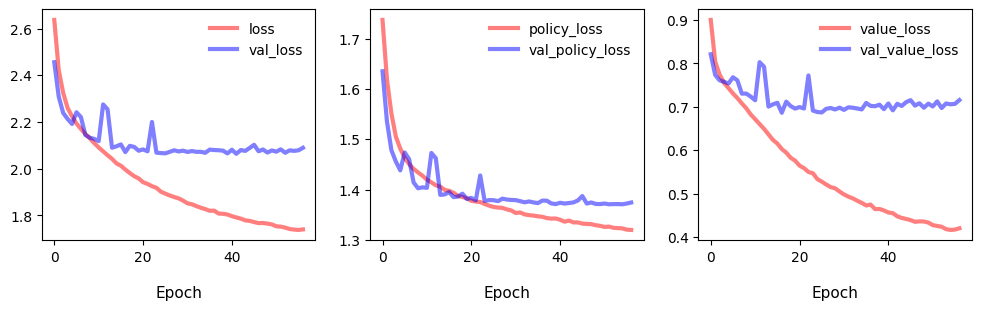

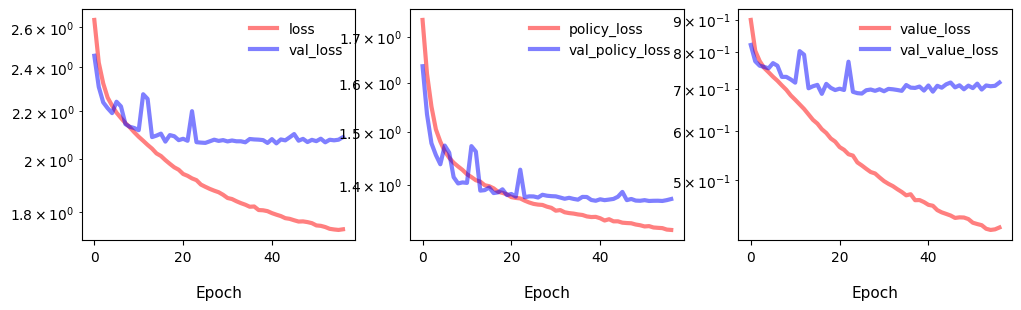

Evaluating model
Evaluating model ../models/test_run/neural_model_v14.h5
Generated 350 / 350 results [t=442.08s]
Generation complete [t=442.09s] [n=350]
Saving tournament results to file ../data/test_run/eval_data_v14.pickle
Evaluating results
Results (LHS player goes first):
  [VANILLA]  93 - 13 - 82  [NEW MODEL]
[NEW MODEL]  94 - 3 - 65  [VANILLA]
Using old model: ../models/test_run/neural_model_v14.h5
Using new model: ../models/test_run/neural_model_v15.h5
Using data file: ../data/test_run/training_data_v15.pickle
Generating data
Generating 3500 games with base seed 1674629208
Using duration = 0.300
Using discount = 0.990
Generated 3500 / 3500 results [t=2769.97s]
Generation complete [t=2769.97s] [n=3500]
Generated 60994 datapoints with average of 17.4 turns per game
model_in with shape: (60994, 7, 6, 1)
model_p  with shape: (60994, 7)
model_v  with shape: (60994, 1)
Saving data to file: ../data/test_run/training_data_v15.pickle
Pre-processing and splitting data
Created training set

                                                                                                  
 dense3_dropout (Dropout)       (None, 200)          0           ['dense3_batchnorm[0][0]']       
                                                                                                  
 dense4_feedforward (Dense)     (None, 200)          40200       ['dense3_dropout[0][0]']         
                                                                                                  
 dense4_batchnorm (BatchNormali  (None, 200)         800         ['dense4_feedforward[0][0]']     
 zation)                                                                                          
                                                                                                  
 dense4_dropout (Dropout)       (None, 200)          0           ['dense4_batchnorm[0][0]']       
                                                                                                  
 policy_pr

2023-01-25 07:33:00.920928: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


427/427 [==============================] - 17s 36ms/step - loss: 2.6573 - policy_loss: 1.7300 - value_loss: 0.9273 - val_loss: 2.4704 - val_policy_loss: 1.6429 - val_value_loss: 0.8275
Epoch 2/1000
427/427 [==============================] - 17s 41ms/step - loss: 2.4345 - policy_loss: 1.6134 - value_loss: 0.8212 - val_loss: 2.3357 - val_policy_loss: 1.5455 - val_value_loss: 0.7902
Epoch 3/1000
427/427 [==============================] - 18s 43ms/step - loss: 2.3408 - policy_loss: 1.5545 - value_loss: 0.7863 - val_loss: 2.2690 - val_policy_loss: 1.4946 - val_value_loss: 0.7744
Epoch 4/1000
427/427 [==============================] - 18s 42ms/step - loss: 2.2848 - policy_loss: 1.5159 - value_loss: 0.7689 - val_loss: 2.2563 - val_policy_loss: 1.4804 - val_value_loss: 0.7759
Epoch 5/1000
427/427 [==============================] - 18s 41ms/step - loss: 2.2426 - policy_loss: 1.4894 - value_loss: 0.7532 - val_loss: 2.2012 - val_policy_loss: 1.4428 - val_value_loss: 0.7584
Epoch 6/1000
427/427 [=

427/427 [==============================] - 20s 46ms/step - loss: 1.8014 - policy_loss: 1.3480 - value_loss: 0.4534 - val_loss: 2.0755 - val_policy_loss: 1.3815 - val_value_loss: 0.6941
Epoch 43/1000
427/427 [==============================] - 20s 47ms/step - loss: 1.8059 - policy_loss: 1.3468 - value_loss: 0.4591 - val_loss: 2.0708 - val_policy_loss: 1.3810 - val_value_loss: 0.6898
Epoch 44/1000
427/427 [==============================] - 20s 48ms/step - loss: 1.8002 - policy_loss: 1.3474 - value_loss: 0.4528 - val_loss: 2.0796 - val_policy_loss: 1.3803 - val_value_loss: 0.6993
Epoch 45/1000
427/427 [==============================] - 20s 47ms/step - loss: 1.7943 - policy_loss: 1.3448 - value_loss: 0.4495 - val_loss: 2.0762 - val_policy_loss: 1.3800 - val_value_loss: 0.6962
Saving model to file ../models/test_run/neural_model_v15.h5
Showing training curves


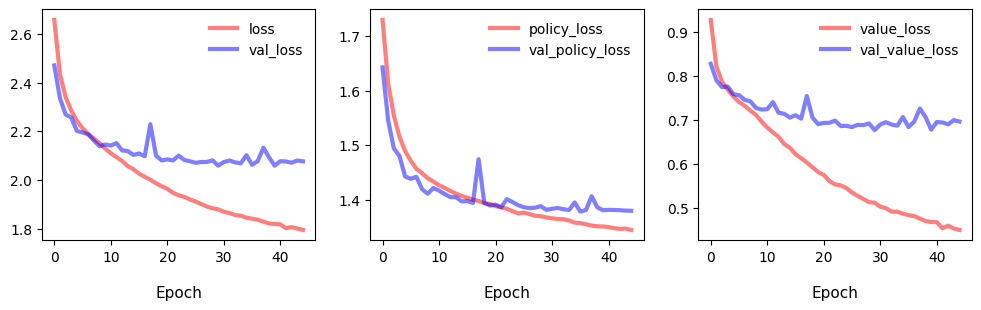

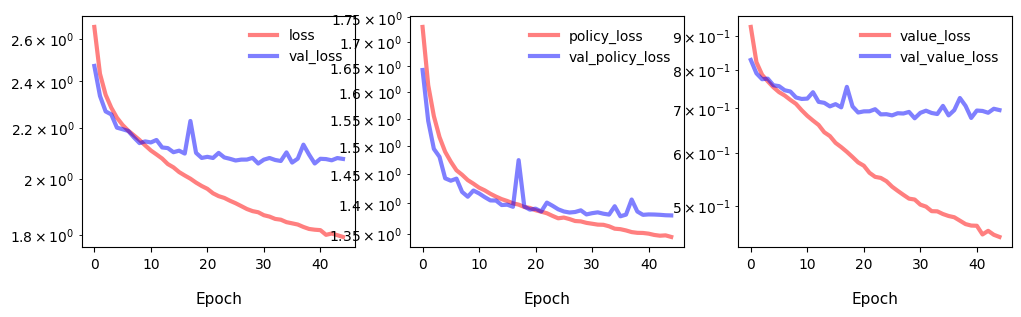

Evaluating model
Evaluating model ../models/test_run/neural_model_v15.h5
Generated 350 / 350 results [t=402.99s]
Generation complete [t=402.99s] [n=350]
Saving tournament results to file ../data/test_run/eval_data_v15.pickle
Evaluating results
Results (LHS player goes first):
  [VANILLA]  90 - 16 - 86  [NEW MODEL]
[NEW MODEL]  100 - 3 - 55  [VANILLA]
Using old model: ../models/test_run/neural_model_v15.h5
Using new model: ../models/test_run/neural_model_v16.h5
Using data file: ../data/test_run/training_data_v16.pickle
Generating data
Generating 3500 games with base seed 1674633255
Using duration = 0.300
Using discount = 0.990
Generated 3068 / 3500 results [t=2433.16s]

Process Process-231:
Process Process-227:
Process Process-232:
Process Process-226:
Process Process-228:
Process Process-230:
Process Process-229:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/Ste/miniforge3/envs/py3p10_221222/lib/python3.10/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/Ste/miniforge3/envs/py3p10_221222/lib/python3.10/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/Ste/miniforge3/envs/py3p10_221222/lib/python3.10/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/Users/Ste/miniforge3/envs/py3p10_221222/lib/python3.10/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent 

  File "/Users/Ste/PROJECTS/misc/ML-sandbox/ML-sandbox/Project_Connect4/connect4/bot.py", line 181, in take_move
    action = self.choose_action(game_board, duration, max_sim_steps, discount, create_new_root_node, policy_strategy, debug_lvl)
  File "/Users/Ste/PROJECTS/misc/ML-sandbox/ML-sandbox/Project_Connect4/connect4/MCTS.py", line 266, in one_step_MCTS
    leaf_node = self.select_and_expand(recurse=True, debug_lvl=debug_lvl)
  File "/Users/Ste/PROJECTS/misc/ML-sandbox/ML-sandbox/Project_Connect4/connect4/bot.py", line 105, in choose_action
    root_node.timed_MCTS(duration      = duration     ,
  File "/Users/Ste/PROJECTS/misc/ML-sandbox/ML-sandbox/Project_Connect4/connect4/bot.py", line 105, in choose_action
    root_node.timed_MCTS(duration      = duration     ,
  File "/Users/Ste/PROJECTS/misc/ML-sandbox/ML-sandbox/Project_Connect4/connect4/MCTS.py", line 266, in one_step_MCTS
    leaf_node = self.select_and_expand(recurse=True, debug_lvl=debug_lvl)
  File "/Users/Ste/PROJECTS/

  File "/Users/Ste/miniforge3/envs/py3p10_221222/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/Users/Ste/miniforge3/envs/py3p10_221222/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/Users/Ste/PROJECTS/misc/ML-sandbox/ML-sandbox/Project_Connect4/connect4/MCTS.py", line 303, in select_and_expand
    self.children[a_idx] = self.__class__(new_game_board, parent=self, params=self.params, shallow_copy_board=True,
  [Previous line repeated 1 more time]
  File "/Users/Ste/PROJECTS/misc/ML-sandbox/ML-sandbox/Project_Connect4/connect4/MCTS.py", line 508, in __init__
    self.child_priors, self.prior_value = self.model(model_input)
  File "/Users/Ste/miniforge3/envs/py3p10_221222/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/Users/Ste/miniforge3/envs/py3p1

  File "/Users/Ste/miniforge3/envs/py3p10_221222/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
    return fn(*args, **kwargs)
  File "/Users/Ste/miniforge3/envs/py3p10_221222/lib/python3.10/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
    outputs = node.layer(*args, **kwargs)
  File "/Users/Ste/miniforge3/envs/py3p10_221222/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/Users/Ste/miniforge3/envs/py3p10_221222/lib/python3.10/site-packages/keras/engine/functional.py", line 511, in call
    return self._run_internal_graph(inputs, training=training, mask=mask)
  File "/Users/Ste/miniforge3/envs/py3p10_221222/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 160, in inject_argument_info_in_traceback
    return tf.__internal__.decorator.make_decorator(fn, error_handler)
  File "/Users/Ste/miniforge3/envs/py3p10_221222/lib/p

  File "/Users/Ste/miniforge3/envs/py3p10_221222/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 255, in convolution_op
    return tf.nn.convolution(
  File "/Users/Ste/miniforge3/envs/py3p10_221222/lib/python3.10/site-packages/tensorflow/python/ops/nn_ops.py", line 3554, in bias_add
    return gen_nn_ops.bias_add(value, bias, data_format=data_format, name=name)
  File "/Users/Ste/miniforge3/envs/py3p10_221222/lib/python3.10/site-packages/tensorflow/python/ops/nn_impl.py", line 1594, in batch_normalization
    offset - mean * inv if offset is not None else -mean * inv, x.dtype)
  File "/Users/Ste/miniforge3/envs/py3p10_221222/lib/python3.10/site-packages/tensorflow/python/ops/math_ops.py", line 1407, in binary_op_wrapper
    return func(x, y, name=name)
  File "/Users/Ste/miniforge3/envs/py3p10_221222/lib/python3.10/site-packages/tensorflow/python/ops/nn_ops.py", line 1313, in convolution_internal
    return op(
  File "/Users/Ste/miniforge3/envs/py3p10_2212

In [9]:

model_idx = 1

while True :
    train_model_iteration(model_idx)
    model_idx += 1
    base_seed = int(time.time())
    